In [8]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import models,datasets
import urllib
import zipfile
import glob 
import os

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
# !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
# !unzip "/home/euclid/Desktop/Chiranjeev/tiny-imagenet-200.zip" -d "/home/euclid/Desktop/Chiranjeev/Tiny_Imagenet"


In [14]:
folders = sorted(glob.glob("/home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/train/*"))
# folders[:50]

In [15]:
folders = sorted(glob.glob("/home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/train/*"))
folders50 = folders[:50]
removing_class_ids = folders[50:]

with open("/home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/words.txt") as f:
    lines = f.readlines()
all_class_ids = []
all_class_names = []
for i in lines:
  strings = i.split("\t")
  all_class_ids.append(strings[0])
  all_class_names.append(strings[1][:-1])

class_ids50 = []
class_names50 = []

for fold in folders50:
  id = fold.split("/")[-1]
  idx = all_class_ids.index(id)
  class_ids50.append(id)
  class_names50.append(all_class_names[idx])


In [14]:
# import os
# import shutil

# ctr = 0 

# for rd in removing_class_ids:
#   folder_path = rd
#   if os.path.exists(folder_path):
#     ctr+=1
#     print(ctr,rd)
#     shutil.rmtree(folder_path)
#   else:
#     print("file not found",rd)
    


1 /home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/train/n02410509
2 /home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/train/n02415577
3 /home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/train/n02423022
4 /home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/train/n02437312
5 /home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/train/n02480495
6 /home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/train/n02481823
7 /home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/train/n02486410
8 /home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/train/n02504458
9 /home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/train/n02509815
10 /home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/train/n02666196
11 /home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/train/n02669723
12 /home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/train/n02699494
13 /home/eucl

In [11]:
def create_dataset(data_dir,name,transform,batch_size):
    if data_dir is None: 
      return None
    
    if transform is None:
        dataset = datasets.ImageFolder(data_dir, transform=transforms.ToTensor())
    else:
        dataset = datasets.ImageFolder(data_dir, transform=transform)
    
    dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True)

    return dataloader


transform = transforms.Compose([
                transforms.Resize(224), 
                transforms.CenterCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(), 
                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
              ])

batch_size=64

TRAIN_DIR ='/home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/train' 

train_dataloader = create_dataset(TRAIN_DIR, "train",transform=transform,batch_size=64)


## Question2(b) - Categorical Cross Entropy loss 

In [12]:
VALID_DIR = '/home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/val' 
val_img_dir = os.path.join(VALID_DIR, 'images')
# file2 = open(os.path.join(VALID_DIR, 'val_annotations.txt'), 'r')
# data = file2.readlines()

# val_img_dict = {}
# for line in data:
#     words = line.split('\t')
#     if words[1] in class_ids50:
#       val_img_dict[words[0]] = words[1]
# file2.close()


# for img, folder in val_img_dict.items():
#     newpath = (os.path.join(val_img_dir, folder))
#     if not os.path.exists(newpath):
#         os.makedirs(newpath)
#     if os.path.exists(os.path.join(val_img_dir, img)):
#         os.rename(os.path.join(val_img_dir, img), os.path.join(newpath, img))
        
val_dataloader= create_dataset(val_img_dir, "val",transform=transform,batch_size=64)

In [13]:
print(len(train_dataloader))
print(len(val_dataloader))

391
40


In [35]:
class_names = class_names50

def test(dataloader,model,criterion,purpose="test"):
    batch_size=64
    with torch.no_grad():
        test_loss = 0.0
        test_correct = 0
        for idx,batch in enumerate(dataloader):
            imgs,lbls = batch
            imgs = imgs.float()
            lbls = lbls.long()
            
            imgs = imgs.to(device)
            lbls = lbls.to(device)
            out = model(imgs)
            loss = criterion(out,lbls)

            test_loss += loss.item()
                
            test_pred = torch.argmax(out, dim=1)
            test_correct += torch.sum(test_pred == lbls)
            
        test_loss = test_loss/float(len(dataloader))
        test_acc = float(float(test_correct)/float(len(dataloader)*batch_size))

        if purpose == "test": 
            for idx,batch in enumerate(dataloader):
              imgs,lbls = batch
              imgs = imgs.float().to(device)
              out = model(imgs)
              test_pred = torch.argmax(out, dim=1)
              for i in range(10):
                img = imgs[i]
                actual_lbl = lbls[i].detach().cpu().numpy()
                pred_lbl = test_pred[i].detach().cpu().numpy()

                img_disp = img.permute(1,2,0).detach().cpu().numpy()
                actual_lbl_disp = actual_lbl
                pred_lbl_disp = pred_lbl
                print("actual_label:",class_names[actual_lbl_disp],"\tpredicted_label:",class_names[pred_lbl_disp])
                plt.imshow(img_disp)
                plt.show()
              break
                        
            
    
    return test_loss,test_acc

cuda


100%|██████████| 391/391 [00:38<00:00, 10.16it/s, batch_loss=2.3631324768066406]



epoch: 0  Train Loss: 3.2660063977741522  Train Accuracy: 0.23221707161125318


100%|██████████| 391/391 [00:38<00:00, 10.08it/s, batch_loss=1.688433289527893] 



epoch: 1  Train Loss: 2.1473351988341194  Train Accuracy: 0.5472746163682864


100%|██████████| 391/391 [00:38<00:00, 10.22it/s, batch_loss=1.6170762777328491]



epoch: 2  Train Loss: 1.643115722919669  Train Accuracy: 0.6407049232736572


100%|██████████| 391/391 [00:38<00:00, 10.20it/s, batch_loss=1.4575536251068115]



epoch: 3  Train Loss: 1.3610779364090746  Train Accuracy: 0.691775895140665


100%|██████████| 391/391 [00:38<00:00, 10.12it/s, batch_loss=0.8998668789863586]



epoch: 4  Train Loss: 1.172997206983054  Train Accuracy: 0.7281010230179028


100%|██████████| 391/391 [00:38<00:00, 10.25it/s, batch_loss=1.1576788425445557]



epoch: 5  Train Loss: 1.03804419382149  Train Accuracy: 0.7521179667519181


100%|██████████| 391/391 [00:38<00:00, 10.19it/s, batch_loss=0.8010594248771667]



epoch: 6  Train Loss: 0.931527257727845  Train Accuracy: 0.7744964833759591


100%|██████████| 391/391 [00:38<00:00, 10.20it/s, batch_loss=0.5572748780250549]



epoch: 7  Train Loss: 0.8438546369447733  Train Accuracy: 0.7954763427109974


100%|██████████| 391/391 [00:38<00:00, 10.24it/s, batch_loss=0.7976051568984985] 



epoch: 8  Train Loss: 0.7640109545434527  Train Accuracy: 0.814178388746803


100%|██████████| 391/391 [00:38<00:00, 10.25it/s, batch_loss=0.5963293313980103] 



epoch: 9  Train Loss: 0.6911829981352667  Train Accuracy: 0.8342790920716112


100%|██████████| 391/391 [00:38<00:00, 10.23it/s, batch_loss=0.7242645025253296] 



epoch: 10  Train Loss: 0.6329997256588753  Train Accuracy: 0.8493845907928389


100%|██████████| 391/391 [00:37<00:00, 10.37it/s, batch_loss=0.5797301530838013] 



epoch: 11  Train Loss: 0.5751991913751568  Train Accuracy: 0.8668478260869565


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Chihuahua 	predicted_label: Chihuahua


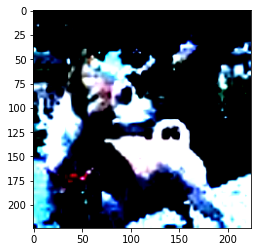

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: tabby, tabby cat 	predicted_label: Egyptian cat


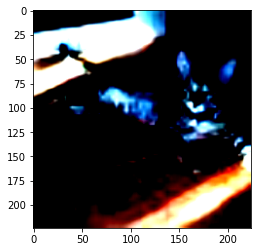

actual_label: Egyptian cat 	predicted_label: tabby, tabby cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


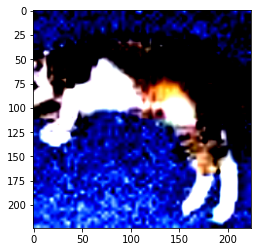

actual_label: sulphur butterfly, sulfur butterfly 	predicted_label: sulphur butterfly, sulfur butterfly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


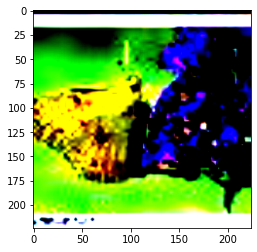

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: standard poodle 	predicted_label: standard poodle


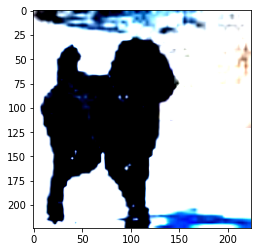

actual_label: albatross, mollymawk 	predicted_label: Chihuahua


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


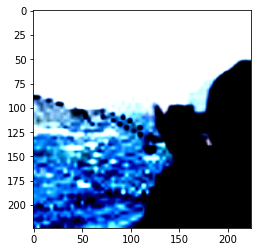

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: dugong, Dugong dugon 	predicted_label: dugong, Dugong dugon


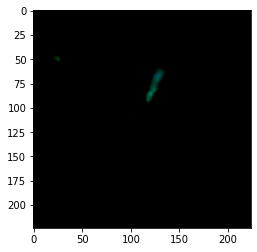

actual_label: black stork, Ciconia nigra 	predicted_label: black stork, Ciconia nigra


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


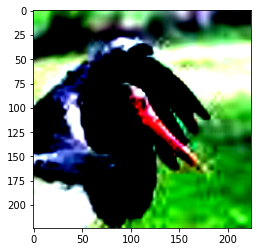

actual_label: black stork, Ciconia nigra 	predicted_label: black stork, Ciconia nigra


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


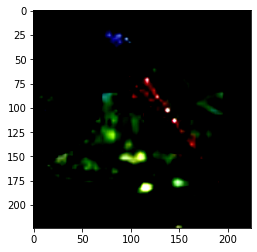

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: monarch, monarch butterfly, milkweed butterfly, Danaus plexippus 	predicted_label: monarch, monarch butterfly, milkweed butterfly, Danaus plexippus


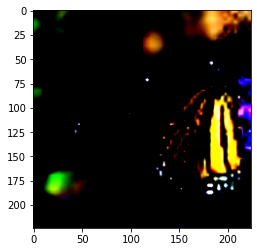


 test accuracy: 73.671875 %


In [36]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)


train_loss = []
validation_loss = []
train_acc = [] 
validation_acc = []

num_epochs = 12
learning_rate = 0.00001

batch_size=64

resnet18 = models.resnet18(pretrained=True)
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 50)  

ct=0
for child in resnet18.children():
  ct += 1

  if ct < 7:      
      for params in child.parameters():
          params.requires_grad = False

model = resnet18.to(device)
model.train()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-4)

for epoch in range(num_epochs):
  running_loss = 0.0
  running_correct = 0
  model.train()
  with tqdm(total=len(train_dataloader)) as pbar:  
    for idx,batch in enumerate(train_dataloader):
      imgs,lbls = batch
      imgs = imgs.float()
      lbls = lbls.long()
      
      imgs = imgs.to(device)
      lbls = lbls.to(device)
    
      optimizer.zero_grad()

      out = model(imgs)
      loss = criterion(out,lbls)

      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      num_correct = torch.sum(torch.argmax(out, dim=1) == lbls).item()

      running_correct += num_correct

      pbar.set_postfix(batch_loss='{}'.format(loss.item()))
      pbar.update(1)      
    
  train_loss.append(running_loss/float(len(train_dataloader)))
  train_acc.append(running_correct/float(len(train_dataloader)*batch_size))


  print("\nepoch:",epoch," Train Loss:",running_loss/float(len(train_dataloader))," Train Accuracy:",running_correct/float(len(train_dataloader)*batch_size))




model.eval()
test_loss,test_acc = test(val_dataloader,model,criterion,purpose="test")
print("\n test accuracy:",test_acc*100,"%")





Confusion Matrix


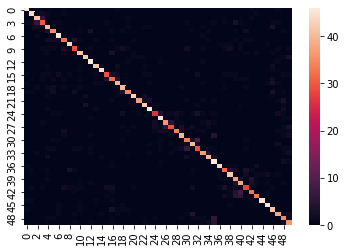


Classification Report
              precision    recall  f1-score   support

           0       0.87      0.92      0.89        50
           1       0.88      0.88      0.88        50
           2       0.76      0.82      0.79        50
           3       0.70      0.60      0.65        50
           4       0.67      0.80      0.73        50
           5       0.70      0.70      0.70        50
           6       0.82      0.92      0.87        50
           7       0.71      0.64      0.67        50
           8       0.88      0.88      0.88        50
           9       0.69      0.58      0.63        50
          10       0.80      0.82      0.81        50
          11       0.89      0.84      0.87        50
          12       0.81      0.92      0.86        50
          13       0.89      0.84      0.87        50
          14       0.90      0.90      0.90        50
          15       0.76      0.58      0.66        50
          16       0.64      0.64      0.64        50
    

In [37]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
y_pred = []
y_true = []

for idx,batch in enumerate(val_dataloader):
  imgs,lbls = batch
  imgs = imgs.float()
  lbls = lbls
  imgs = imgs.to(device)
  lbls = lbls.to(device)
  
  out = model(imgs)

  out_np = torch.argmax(out, dim=1).detach().cpu().numpy()
  lbls_np = lbls.detach().cpu().numpy()
  
  for i in range(len(lbls_np)):
    y_pred.append(out_np[i])
    y_true.append(lbls_np[i])


y_true = np.array(y_true)
y_pred = np.array(y_pred)

import seaborn as sns
cf_matrix = confusion_matrix(y_true,y_pred)
print("\nConfusion Matrix")
sns.heatmap(cf_matrix, annot=False)
plt.show()

print("\nClassification Report")
print(classification_report(y_true,y_pred))




# Question 2(a) - Triplet Loss

In [38]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Dataset
from torchvision import models,datasets
import urllib
import zipfile
import glob 
import os
# from CenterLoss import CenterLoss
from center_loss import CenterLoss
import cv2
from PIL import Image

In [39]:
folders = sorted(glob.glob("/home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/train/*"))
folders50 = folders[:50]
removing_class_ids = folders[50:]

with open("/home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/words.txt") as f:
    lines = f.readlines()
all_class_ids = []
all_class_names = []
for i in lines:
  strings = i.split("\t")
  all_class_ids.append(strings[0])
  all_class_names.append(strings[1][:-1])

class_ids50 = []
class_names50 = []

for fold in folders50:
  id = fold.split("/")[-1]
  idx = all_class_ids.index(id)
  class_ids50.append(id)
  class_names50.append(all_class_names[idx])



In [3]:
# from glob import glob
# import random
# TRAIN_DIR ='/home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/train' 
# ctrr=0
# triplets = []
# for id in range(len(class_ids50)):
#     anchor_files = glob("/home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/train/"+class_ids50[id]+"/images/*") 
#     for file in anchor_files:
#         anchor = file
#         positive = random.choice(anchor_files)
#         while(positive==anchor):
#             positive = random.choice(anchor_files)
#         negative_files = random.choices(class_ids50[:id]+class_ids50[id+1:],k=5)
#         for neg in negative_files:
#             negative_file = random.choice(glob("/home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/train/"+neg+"/images/*"))
#             triplets.append([anchor,positive,negative_file,class_ids50[id]])
#             ctr+=1
# print(ctr)
# np.save("/home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/triplets.npy",np.array(triplets))

# from glob import glob
# import random
# VAL_DIR ='/home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/val' 
# ctr=0
# triplets_val = []
# for id in range(len(class_ids50)):
#     anchor_files = glob("/home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/val/images/"+class_ids50[id]+"/*") 

    
#     for file in anchor_files:
#         anchor = file
#         positive = random.choice(anchor_files)
#         while(positive==anchor):
#             positive = random.choice(anchor_files)
#         negative_files = random.choices(class_ids50[:id]+class_ids50[id+1:],k=3)
#         for neg in negative_files:
#             negative_file = random.choice(glob("/home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/val/images/"+neg+"/*"))
#             triplets_val.append([anchor,positive,negative_file,class_ids50[id]])
#             ctr+=1
# ctr
# # np.save("/home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/triplets_val.npy",np.array(triplets_val))

In [40]:
from sklearn import preprocessing
class TinyImagenet(Dataset):

  def __init__(self,triplets_file,labels,transform=None):
    self.triplets_file = triplets_file
    self.transform = transform
    self.labels = labels
  def __len__(self):
    return len(self.triplets_file)

  def __getitem__(self,idx):
    anchor = cv2.imread(self.triplets_file[idx][0])
    positive = cv2.imread(self.triplets_file[idx][1])
    negative = cv2.imread(self.triplets_file[idx][2])
    label = self.labels[idx]

    if self.transform:
      anchor = self.transform(anchor)
      positive = self.transform(positive)
      negative = self.transform(negative)

    
    return anchor,positive,negative,label
    

class ToTransform:

  def __call__(self,image):
    

    transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize(224), 
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.RandomHorizontalFlip(), 
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                    std=[0.229, 0.224, 0.225])
                  ])

    image = transform(image)
    return image



train_file = np.load("/home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/triplets.npy",allow_pickle=True)
valid_file = np.load("/home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/triplets_val.npy",allow_pickle=True)


train_le = preprocessing.LabelEncoder()
train_le.fit(train_file[:,-1])
train_labels = np.array(train_le.transform(train_file[:,-1]))

valid_le = preprocessing.LabelEncoder()
valid_le.fit(valid_file[:,-1])
valid_labels = np.array(valid_le.transform(valid_file[:,-1]))

train_dataset = TinyImagenet(train_file,train_labels,transform = ToTransform())
valid_dataset = TinyImagenet(valid_file,valid_labels,transform = ToTransform())

batch_size = 64
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,num_workers = 2, shuffle=True,worker_init_fn = np.random.seed(42))
val_dataloader = DataLoader(valid_dataset,batch_size=batch_size,num_workers = 2, shuffle=False)


print(len(train_dataloader))
print(len(val_dataloader))


1954
118


In [41]:
class_names = class_names50

def test(dataloader,model,criterion,tripletloss,purpose="test"):
    
    features = {}
    def get_features(name):
        def hook(model, input, output):
            features[name] = output.detach()
        return hook

    model.layer4[1].bn2.register_forward_hook(get_features('feats'))
    batch_size=64
    with torch.no_grad():
        test_loss = 0.0
        test_correct = 0
        for idx,batch in enumerate(dataloader):
            
          a,p,n,lbls = batch

          a,p,n = a.float(),p.float(),n.float()
          lbls = lbls.long()
          a,p,n = a.to(device),p.to(device),n.to(device)  
          lbls = lbls.to(device)

          optimizer_cross.zero_grad()
          optimizer_triplet.zero_grad()

          a_out = model(a)
          avgpool_features_a = features['feats'].view(features['feats'].size(0),-1)
          avgpool_features_a = torch.nn.functional.normalize(avgpool_features_a, p=2.0, dim=1)

          p_out = model(p)
          avgpool_features_p = features['feats'].view(features['feats'].size(0),-1) 
          avgpool_features_p = torch.nn.functional.normalize(avgpool_features_p, p=2.0, dim=1)

          n_out = model(n) 
          avgpool_features_n = features['feats'].view(features['feats'].size(0),-1)
          avgpool_features_n = torch.nn.functional.normalize(avgpool_features_n, p=2.0, dim=1)

          #print(avgpool_features.shape)
          cross_entropy_loss = criterion(a_out,lbls)
          triplet_loss = tripletloss(avgpool_features_a,avgpool_features_p,avgpool_features_n)
          weight=1
          loss = cross_entropy_loss + weight*triplet_loss
            
          test_loss += loss.item()
          test_pred = torch.argmax(a_out, dim=1)
          test_correct += torch.sum(test_pred == lbls)  
  
        test_loss = test_loss/float(len(dataloader))
        test_acc = float(float(test_correct)/float(len(dataloader)*batch_size))
                        
            
    
    return test_loss,test_acc

In [42]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)
 
train_loss = []
validation_loss = []
train_acc = [] 
validation_acc = []

num_epochs = 11
learning_rate = 0.0001

batch_size=64

resnet18 = models.resnet18(pretrained=True)
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 50)  

ct=0
for child in resnet18.children():
  ct += 1

  if ct < 7:      
      for params in child.parameters():
          params.requires_grad = False

model = resnet18.to(device)
model.train()

criterion = nn.CrossEntropyLoss()
tripletloss = nn.TripletMarginLoss()

optimizer_cross = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-4)
optimizer_triplet = torch.optim.Adam(model.parameters(),lr=0.001)
features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

model.layer4[1].bn2.register_forward_hook(get_features('feats'))

for epoch in range(num_epochs):
  running_loss = 0.0
  running_correct = 0
  model.train()
  with tqdm(total=len(train_dataloader)) as pbar:  
    for idx,batch in enumerate(train_dataloader):
            
      a,p,n,lbls = batch

      a,p,n = a.float(),p.float(),n.float()
      lbls = lbls.long()
      a,p,n = a.to(device),p.to(device),n.to(device)  
      lbls = lbls.to(device)

      optimizer_cross.zero_grad()
      optimizer_triplet.zero_grad()

      a_out = model(a)
      avgpool_features_a = features['feats'].view(features['feats'].size(0),-1)
      avgpool_features_a = torch.nn.functional.normalize(avgpool_features_a, p=2.0, dim=1)
    
      p_out = model(p)
      avgpool_features_p = features['feats'].view(features['feats'].size(0),-1) 
      avgpool_features_p = torch.nn.functional.normalize(avgpool_features_p, p=2.0, dim=1)
      
      n_out = model(n) 
      avgpool_features_n = features['feats'].view(features['feats'].size(0),-1)
      avgpool_features_n = torch.nn.functional.normalize(avgpool_features_n, p=2.0, dim=1)
    
      cross_entropy_loss = criterion(a_out,lbls)
      triplet_loss = tripletloss(avgpool_features_a,avgpool_features_p,avgpool_features_n)
      weight=1
      loss = cross_entropy_loss + weight*triplet_loss
        
      loss.backward()
    
      optimizer_cross.step()
      optimizer_triplet.step()

      running_loss += loss.item()
      num_correct = torch.sum(torch.argmax(a_out, dim=1) == lbls).item()

      running_correct += num_correct

      pbar.set_postfix(batch_loss='{}'.format(loss.item()),cross_entropy_loss='{}'.format(cross_entropy_loss.item()),triplet_loss='{}'.format(triplet_loss.item()))
      pbar.update(1)      
  
  train_loss.append(running_loss/float(len(train_dataloader)))
  train_acc.append(running_correct/float(len(train_dataloader)*batch_size))


  print("\nepoch:",epoch," Train Loss:",running_loss/float(len(train_dataloader))," Train Accuracy:",running_correct/float(len(train_dataloader)*batch_size))#," Validation Loss:",val_loss," Validation Accuracy:",val_acc,"\n")


model.eval()
test_loss,test_acc = test(val_dataloader,model,criterion,tripletloss,purpose="test")#test(test_dataloader,model,criterion,purpose="test")
print("\n test accuracy:",test_acc*100,"%")



cuda


100%|██████████| 1954/1954 [04:14<00:00,  7.67it/s, batch_loss=2.093578338623047, cross_entropy_loss=1.2448488473892212, triplet_loss=0.8487296104431152]  



epoch: 0  Train Loss: 1.8101282017257831  Train Accuracy: 0.7035727993858751


100%|██████████| 1954/1954 [04:17<00:00,  7.60it/s, batch_loss=1.3953638076782227, cross_entropy_loss=0.5027981400489807, triplet_loss=0.8925657272338867]  



epoch: 1  Train Loss: 1.0790630635732028  Train Accuracy: 0.9062340071647902


100%|██████████| 1954/1954 [04:15<00:00,  7.66it/s, batch_loss=1.0899564027786255, cross_entropy_loss=0.1902894228696823, triplet_loss=0.8996670246124268]  



epoch: 2  Train Loss: 0.9393120987327462  Train Accuracy: 0.946871801432958


100%|██████████| 1954/1954 [04:14<00:00,  7.68it/s, batch_loss=1.0765024423599243, cross_entropy_loss=0.26640763878822327, triplet_loss=0.8100947737693787] 



epoch: 3  Train Loss: 0.8946113791717112  Train Accuracy: 0.960385747185261


100%|██████████| 1954/1954 [04:15<00:00,  7.64it/s, batch_loss=2.1515164375305176, cross_entropy_loss=1.3554234504699707, triplet_loss=0.7960931062698364]  



epoch: 4  Train Loss: 0.8851921837490925  Train Accuracy: 0.9636482855680655


100%|██████████| 1954/1954 [04:16<00:00,  7.63it/s, batch_loss=2.239367961883545, cross_entropy_loss=1.3812625408172607, triplet_loss=0.8581054210662842]   



epoch: 5  Train Loss: 0.863414938093574  Train Accuracy: 0.9711409288638689


100%|██████████| 1954/1954 [04:15<00:00,  7.64it/s, batch_loss=1.1483256816864014, cross_entropy_loss=0.3468874394893646, triplet_loss=0.8014382719993591]   



epoch: 6  Train Loss: 0.8578797094409517  Train Accuracy: 0.9729721084953941


100%|██████████| 1954/1954 [04:16<00:00,  7.62it/s, batch_loss=0.7662134766578674, cross_entropy_loss=0.00239070993848145, triplet_loss=0.7638227939605713]  



epoch: 7  Train Loss: 0.8501268484331325  Train Accuracy: 0.9752990660184238


100%|██████████| 1954/1954 [04:16<00:00,  7.62it/s, batch_loss=1.8799077272415161, cross_entropy_loss=0.9787457585334778, triplet_loss=0.9011619687080383]   



epoch: 8  Train Loss: 0.8486329203008264  Train Accuracy: 0.9759787615148413


100%|██████████| 1954/1954 [04:17<00:00,  7.59it/s, batch_loss=0.950837254524231, cross_entropy_loss=0.13098235428333282, triplet_loss=0.8198549151420593]   



epoch: 9  Train Loss: 0.8428522665339581  Train Accuracy: 0.9777459698055271


100%|██████████| 1954/1954 [04:16<00:00,  7.61it/s, batch_loss=2.513827085494995, cross_entropy_loss=1.706492304801941, triplet_loss=0.8073347806930542]     


epoch: 10  Train Loss: 0.8402087778432586  Train Accuracy: 0.9793612461617196



 test accuracy: 61.67902542372882 %



Confusion Matrix


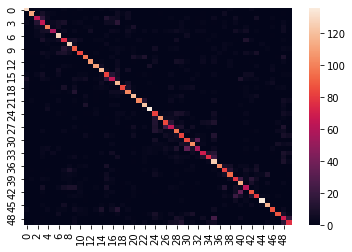


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       150
           1       0.92      0.75      0.82       150
           2       0.65      0.43      0.52       150
           3       0.41      0.43      0.42       150
           4       0.67      0.66      0.66       150
           5       0.69      0.37      0.48       150
           6       0.68      0.85      0.75       150
           7       0.47      0.50      0.49       150
           8       0.69      0.85      0.76       150
           9       0.49      0.59      0.54       150
          10       0.72      0.55      0.63       150
          11       0.66      0.65      0.66       150
          12       0.92      0.72      0.81       150
          13       0.81      0.73      0.77       150
          14       0.72      0.79      0.75       150
          15       0.49      0.55      0.51       150
          16       0.44      0.43      0.43       150
    

In [48]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
y_pred = []
y_true = []

for idx,batch in enumerate(val_dataloader):
  a,p,n,lbls = batch
  imgs = a.float()
  lbls = lbls
  imgs = imgs.to(device)
  lbls = lbls.to(device)
  
  out = model(imgs)

  out_np = torch.argmax(out, dim=1).detach().cpu().numpy()
  lbls_np = lbls.detach().cpu().numpy()
  
  for i in range(len(lbls_np)):
    y_pred.append(out_np[i])
    y_true.append(lbls_np[i])


y_true = np.array(y_true)
y_pred = np.array(y_pred)

import seaborn as sns
cf_matrix = confusion_matrix(y_true,y_pred)
print("\nConfusion Matrix")
sns.heatmap(cf_matrix, annot=False)
plt.show()

print("\nClassification Report")
print(classification_report(y_true,y_pred))


# Question 2(c) - Center Loss


In [49]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import models,datasets
import urllib
import zipfile
import glob 
import os
# from CenterLoss import CenterLoss
from center_loss import CenterLoss


In [50]:
folders = sorted(glob.glob("/home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/train/*"))
folders50 = folders[:50]
removing_class_ids = folders[50:]

with open("/home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/words.txt") as f:
    lines = f.readlines()
all_class_ids = []
all_class_names = []
for i in lines:
  strings = i.split("\t")
  all_class_ids.append(strings[0])
  all_class_names.append(strings[1][:-1])

class_ids50 = []
class_names50 = []

for fold in folders50:
  id = fold.split("/")[-1]
  idx = all_class_ids.index(id)
  class_ids50.append(id)
  class_names50.append(all_class_names[idx])



def create_dataset(data_dir,name,transform,batch_size):
    if data_dir is None: 
      return None
    
    if transform is None:
        dataset = datasets.ImageFolder(data_dir, transform=transforms.ToTensor())
    else:
        dataset = datasets.ImageFolder(data_dir, transform=transform)
    
    dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True)#,pin_memory=True,num_workers=2)

    return dataloader


transform = transforms.Compose([
                transforms.Resize(224), 
                transforms.CenterCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(), 
                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
              ])

batch_size=64

TRAIN_DIR ='/home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/train' 
train_dataloader = create_dataset(TRAIN_DIR, "train",transform=transform,batch_size=64)

VALID_DIR = '/home/euclid/Desktop/Chiranjeev/Tiny_Imagenet/tiny-imagenet-200/val' 
val_img_dir = os.path.join(VALID_DIR, 'images')
val_dataloader= create_dataset(val_img_dir, "val",transform=transform,batch_size=64)


print(len(train_dataloader))
print(len(val_dataloader))


391
40


In [51]:
class_names = class_names50

def test(dataloader,model,criterion,purpose="test"):
    batch_size=64
    with torch.no_grad():
        test_loss = 0.0
        test_correct = 0
        for idx,batch in enumerate(dataloader):
            imgs,lbls = batch
            imgs = imgs.float()
            lbls = lbls.long()
            
            imgs = imgs.to(device)
            lbls = lbls.to(device)
            out = model(imgs)
            loss = criterion(out,lbls)

            test_loss += loss.item()
                
            test_pred = torch.argmax(out, dim=1)
            test_correct += torch.sum(test_pred == lbls)
            
        test_loss = test_loss/float(len(dataloader))
        test_acc = float(float(test_correct)/float(len(dataloader)*batch_size))

        if purpose == "test": 
            for idx,batch in enumerate(dataloader):
              imgs,lbls = batch
              imgs = imgs.float().to(device)
              out = model(imgs)
              test_pred = torch.argmax(out, dim=1)
              for i in range(10):
                img = imgs[i]
                actual_lbl = lbls[i].detach().cpu().numpy()
                pred_lbl = test_pred[i].detach().cpu().numpy()
                img_disp = img.permute(1,2,0).detach().cpu().numpy()
                actual_lbl_disp = actual_lbl
                pred_lbl_disp = pred_lbl
                print("actual_label:",class_names[actual_lbl_disp],"predicted_label:",class_names[pred_lbl_disp])
                plt.imshow(img_disp)
                plt.show()
              break
                        
            
    
    return test_loss,test_acc

cuda


  0%|          | 0/391 [00:00<?, ?it/s]/home/euclid/Desktop/Chiranjeev/center_loss.py:34: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  distmat.addmm_(1, -2, x, self.centers.t())
100%|██████████| 391/391 [00:40<00:00,  9.77it/s, batch_loss=3.901340961456299, center_loss=11.530755996704102, cross_entropy_loss=2.748265504837036]  



epoch: 0  Train Loss: 4.584845441686528  Train Accuracy: 0.2500399616368286


100%|██████████| 391/391 [00:38<00:00, 10.08it/s, batch_loss=4.756199836730957, center_loss=28.0566349029541, cross_entropy_loss=1.9505360126495361]   



epoch: 1  Train Loss: 3.259085589357654  Train Accuracy: 0.5421994884910486


100%|██████████| 391/391 [00:38<00:00, 10.08it/s, batch_loss=2.2871346473693848, center_loss=8.801528930664062, cross_entropy_loss=1.4069817066192627] 



epoch: 2  Train Loss: 2.6650810055720533  Train Accuracy: 0.6405450767263428


100%|██████████| 391/391 [00:38<00:00, 10.06it/s, batch_loss=2.330801486968994, center_loss=9.211870193481445, cross_entropy_loss=1.4096143245697021]  



epoch: 3  Train Loss: 2.457244058094366  Train Accuracy: 0.6913762787723785


100%|██████████| 391/391 [00:39<00:00,  9.89it/s, batch_loss=2.040794610977173, center_loss=9.925087928771973, cross_entropy_loss=1.048285722732544]   



epoch: 4  Train Loss: 2.6760879675750537  Train Accuracy: 0.7261828644501279


100%|██████████| 391/391 [00:39<00:00,  9.97it/s, batch_loss=1.956836223602295, center_loss=7.248714447021484, cross_entropy_loss=1.2319648265838623]  



epoch: 5  Train Loss: 2.161926561914137  Train Accuracy: 0.7528772378516624


100%|██████████| 391/391 [00:39<00:00,  9.84it/s, batch_loss=3.172203540802002, center_loss=20.788511276245117, cross_entropy_loss=1.0933524370193481] 



epoch: 6  Train Loss: 2.1010472606819914  Train Accuracy: 0.7787723785166241


100%|██████████| 391/391 [00:39<00:00,  9.91it/s, batch_loss=2.724771738052368, center_loss=18.419567108154297, cross_entropy_loss=0.8828150033950806] 



epoch: 7  Train Loss: 1.921122467731271  Train Accuracy: 0.7965952685421995


100%|██████████| 391/391 [00:39<00:00,  9.93it/s, batch_loss=1.3316205739974976, center_loss=4.694252014160156, cross_entropy_loss=0.8621953725814819]  



epoch: 8  Train Loss: 1.6834069237379772  Train Accuracy: 0.8162164322250639


100%|██████████| 391/391 [00:39<00:00,  9.88it/s, batch_loss=2.009453296661377, center_loss=12.76577377319336, cross_entropy_loss=0.7328758835792542]   



epoch: 9  Train Loss: 1.738478007828793  Train Accuracy: 0.8358375959079284


100%|██████████| 391/391 [00:40<00:00,  9.77it/s, batch_loss=1.4559557437896729, center_loss=5.529449462890625, cross_entropy_loss=0.9030107259750366]  



epoch: 10  Train Loss: 1.8575351963872495  Train Accuracy: 0.850263746803069


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish predicted_label: sea cucumber, holothurian


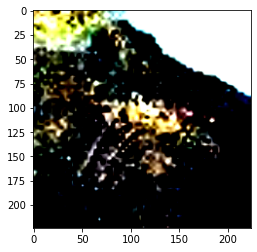

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: bullfrog, Rana catesbeiana predicted_label: bullfrog, Rana catesbeiana


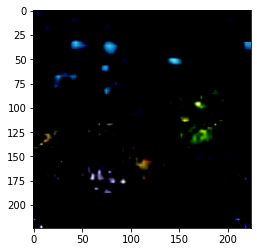

actual_label: Persian cat predicted_label: Persian cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


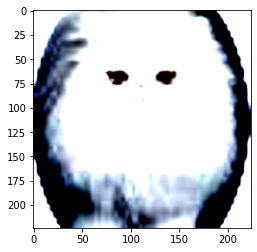

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui predicted_label: sea slug, nudibranch


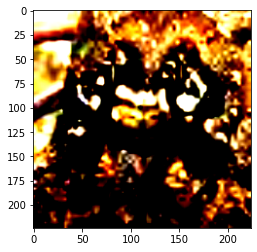

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: bullfrog, Rana catesbeiana predicted_label: bullfrog, Rana catesbeiana


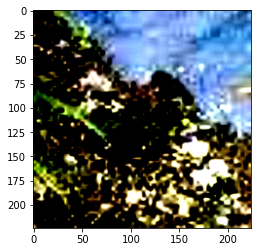

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: boa constrictor, Constrictor constrictor predicted_label: boa constrictor, Constrictor constrictor


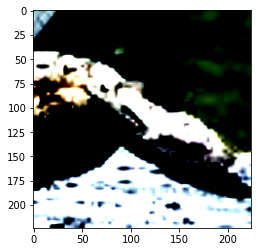

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: tarantula predicted_label: sea cucumber, holothurian


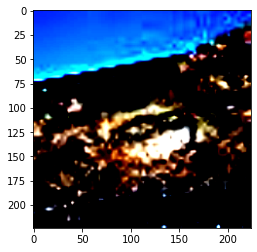

actual_label: goldfish, Carassius auratus predicted_label: goldfish, Carassius auratus


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


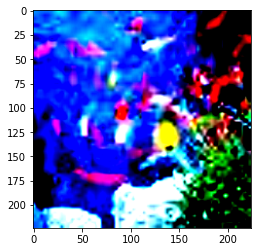

actual_label: Yorkshire terrier predicted_label: Yorkshire terrier


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


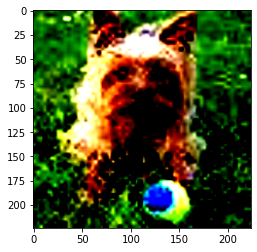

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: snail predicted_label: fly


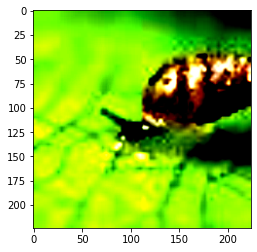


 test accuracy: 72.6171875 %


In [52]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)
 
train_loss = []
validation_loss = []
train_acc = [] 
validation_acc = []

num_epochs = 11
learning_rate = 0.00001

batch_size=64

resnet18 = models.resnet18(pretrained=True)
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 50)  



ct=0
for child in resnet18.children():
  ct += 1

  if ct < 7:      
      for params in child.parameters():
          params.requires_grad = False

model = resnet18.to(device)
model.train()

criterion = nn.CrossEntropyLoss()
centerloss = CenterLoss(num_classes=50, feat_dim=512, use_gpu=True)
optimizer_cross = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-4)
optimizer_center = torch.optim.Adam(centerloss.parameters(),lr=0.5)
features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

model.avgpool.register_forward_hook(get_features('feats'))

for epoch in range(num_epochs):
  running_loss = 0.0
  running_correct = 0
  model.train()
  with tqdm(total=len(train_dataloader)) as pbar:  
    for idx,batch in enumerate(train_dataloader):
      imgs,lbls = batch
      imgs = imgs.float()
      lbls = lbls.long()
      
      imgs = imgs.to(device)
      lbls = lbls.to(device)

      optimizer_cross.zero_grad()
      optimizer_center.zero_grad()

      out = model(imgs)
      avgpool_features = features['feats'].view(-1,512)
      avgpool_features = torch.nn.functional.normalize(avgpool_features, p=2.0, dim=1)
      cross_entropy_loss = criterion(out,lbls)
      center_loss = centerloss(avgpool_features,lbls)
      weight=0.1
      loss = cross_entropy_loss + weight*center_loss
        
      loss.backward()
    
      optimizer_cross.step()
      optimizer_center.step()

      running_loss += loss.item()
      num_correct = torch.sum(torch.argmax(out, dim=1) == lbls).item()

      running_correct += num_correct
        
      pbar.set_postfix(batch_loss='{}'.format(loss.item()),cross_entropy_loss='{}'.format(cross_entropy_loss.item()),center_loss='{}'.format(center_loss))
      pbar.update(1)      
  
  train_loss.append(running_loss/float(len(train_dataloader)))
  train_acc.append(running_correct/float(len(train_dataloader)*batch_size))

  print("\nepoch:",epoch," Train Loss:",running_loss/float(len(train_dataloader))," Train Accuracy:",running_correct/float(len(train_dataloader)*batch_size))#," Validation Loss:",val_loss," Validation Accuracy:",val_acc,"\n")


model.eval()
test_loss,test_acc = test(val_dataloader,model,criterion,purpose="test")
print("\n test accuracy:",test_acc*100,"%")




Confusion Matrix


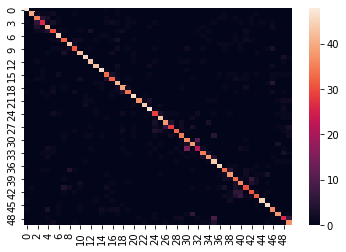


Classification Report
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        50
           1       0.98      0.80      0.88        50
           2       0.70      0.70      0.70        50
           3       0.65      0.52      0.58        50
           4       0.66      0.82      0.73        50
           5       0.65      0.60      0.63        50
           6       0.79      0.90      0.84        50
           7       0.70      0.64      0.67        50
           8       0.85      0.88      0.86        50
           9       0.74      0.62      0.67        50
          10       0.81      0.84      0.82        50
          11       0.88      0.90      0.89        50
          12       0.84      0.86      0.85        50
          13       0.90      0.86      0.88        50
          14       0.85      0.92      0.88        50
          15       0.69      0.66      0.67        50
          16       0.68      0.64      0.66        50
    

In [53]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
y_pred = []
y_true = []

for idx,batch in enumerate(val_dataloader):
  imgs,lbls = batch
  imgs = imgs.float()
  lbls = lbls
  imgs = imgs.to(device)
  lbls = lbls.to(device)
  
  out = model(imgs)

  out_np = torch.argmax(out, dim=1).detach().cpu().numpy()
  lbls_np = lbls.detach().cpu().numpy()
  
  for i in range(len(lbls_np)):
    y_pred.append(out_np[i])
    y_true.append(lbls_np[i])


y_true = np.array(y_true)
y_pred = np.array(y_pred)

import seaborn as sns
cf_matrix = confusion_matrix(y_true,y_pred)
print("\nConfusion Matrix")
sns.heatmap(cf_matrix, annot=False)
plt.show()

print("\nClassification Report")
print(classification_report(y_true,y_pred))


# Question 3

In [192]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn
!pip install split-folders[full]
import splitfolders
# from google.colab.patches import cv2_imshow
import cv2
import glob
from torch.utils.data import Dataset,DataLoader

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
x_train = []
y_train = []

for folder in glob.glob("/content/drive/MyDrive/Cat_Dog/output6/train"+"/*"):
  for file1 in glob.glob(folder+"/*"):
    if folder.split("/")[-1] == 'Cat':
      x_train.append(file1)
      y_train.append(int(0))

    elif folder.split("/")[-1] == 'Dog':
      x_train.append(file1)
      y_train.append(int(1))

x_train = np.array(x_train)
y_train = np.array(y_train)


x_test = []
y_test = []

for folder in glob.glob("/content/drive/MyDrive/Cat_Dog/output6/val"+"/*"):
  for file1 in glob.glob(folder+"/*"):
    if folder.split("/")[-1] == 'Cat':
      x_test.append(file1)
      y_test.append(int(0))

    elif folder.split("/")[-1] == 'Dog':
      x_test.append(file1)
      y_test.append(int(1))

x_test = np.array(x_test)
y_test = np.array(y_test) 

np.save("/content/drive/MyDrive/Cat_Dog/cat_dog_x_train.npy",x_train)
np.save("/content/drive/MyDrive/Cat_Dog/cat_dog_y_train.npy",y_train)
np.save("/content/drive/MyDrive/Cat_Dog/cat_dog_x_test.npy",x_test)
np.save("/content/drive/MyDrive/Cat_Dog/cat_dog_y_test.npy",y_test)

# x_train = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_x_train.npy")
# y_train = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_y_train.npy")
# x_test = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_x_test.npy")
# y_test = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_y_test.npy")

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)




In [198]:
class CNN3(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv1 = nn.Conv2d(3,16,3)
    self.bn1 = nn.BatchNorm2d(16) 
    self.conv2 = nn.Conv2d(16,32,3)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32,64,5)
    self.bn3 = nn.BatchNorm2d(64)

    self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))
    self.flatten_shape =  64 * 22 * 22
    self.linear1 = nn.Linear(in_features=self.flatten_shape,out_features=32)
    self.linear2 = nn.Linear(in_features=32, out_features=16)
    self.linear3 = nn.Linear(in_features=16, out_features=8)
    self.linear4 = nn.Linear(in_features=8, out_features=2)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d((2,2),stride=2)
    self.dropout = nn.Dropout(0.2)


  
  def forward(self,x):
    
    x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
    x = self.maxpool(self.relu(self.bn2(self.conv2(x))))
    x = self.maxpool(self.relu(self.bn3(self.conv3(x))))

    flat_features = x.reshape(-1, x.shape[1] * x.shape[2] * x.shape[3])
    x=self.dropout(self.linear1(flat_features))
    x=self.relu(self.linear2(x))
    x=self.relu(self.linear3(x))

    return x



In [203]:
import copy
class_names = ['Cat', 'Dog']
def test(x,y,model,criterion,transform,purpose="test"):
  
    with torch.no_grad():
        test_loss = 0.0
        test_correct = 0
        c=0
        for sample in zip(x,y):
          img_path,lbl = sample
          img = cv2.imread(img_path.replace('/content/drive/MyDrive/','/DATA1/Chiranjeev/'))
          try:
            img = cv2.resize(img,(200,200))
          except:
            c+=1
            continue
          img = transform(img).unsqueeze(0).float().to(device)
          lbl = torch.Tensor([lbl]).long().to(device)
          

          out = model(img)
          loss = criterion(out,lbl)

          test_loss += loss.item()


          test_pred = torch.argmax(out, dim=1)
          test_correct += torch.sum(test_pred == lbl)



        test_loss = test_loss/float(len(x)-c)
        test_acc = float(float(test_correct)/float(len(x)-c))
        print("samples test",len(x)-c) 

        if purpose == "test": 
            ctr = 0
            x, y = sklearn.utils.shuffle(x, y)
            x, y = sklearn.utils.shuffle(x, y)
            for sample in zip(x,y):
              ctr+=1
              img_path,lbl = sample
              img = cv2.imread(img_path)
              try:
                img = cv2.resize(img,(200,200))
              except:
                #print("test:",img_path)
                continue    
              img_disp=copy.deepcopy(img)
              img = transform(img).unsqueeze(0).float().to(device)        
              out = model(img)

              test_pred = torch.argmax(out, dim=1)
              actual_lbl = lbl 
              pred_lbl = test_pred.item()
              actual_lbl_disp = actual_lbl
              pred_lbl_disp = pred_lbl
              print("actual_label:",class_names[actual_lbl_disp],"predicted_label:",class_names[pred_lbl_disp])
              plt.imshow(img_disp)
              plt.show()
            
              if ctr==10:
                break
                        
    return test_loss,test_acc

In [204]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

model = CNN3()
model = model.to(device)

train_loss = []
validation_loss = []
train_acc = [] 
validation_acc = []

num_epochs = 5
learning_rate = 0.001

batch_size=1


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)#,weight_decay=1e-4)


for epoch in range(num_epochs):
    running_loss = 0.0
    running_correct = 0
    c=0
    model.train()
    x_train, y_train = sklearn.utils.shuffle(x_train, y_train)
    for sample in zip(x_train,y_train):
        img_path,lbl = sample
        img = cv2.imread(img_path.replace('/content/drive/MyDrive/','/DATA1/Chiranjeev/'))
        try:
          img = cv2.resize(img.astype(float),(200,200))   
        except:
          c+=1
          continue
        img = transform(img).unsqueeze(0).float().to(device)
        lbl = torch.Tensor([lbl]).long().to(device)
    
        optimizer.zero_grad()

        out = model(img)
        loss = criterion(out,lbl)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_correct = torch.sum(torch.argmax(out, dim=1) == lbl).item()

        running_correct += num_correct

    print("samples train:",len(x_train)-c)   
    
        
    train_loss.append(running_loss/float(len(x_train)-c))
    train_acc.append(running_correct/float(len(x_train)-c))


    print("\nepoch:",epoch," Train Loss:",running_loss/float(len(x_train)-c)," Train Accuracy:",running_correct/float(len(x_train)-c),"\n")



model.eval()
test_loss,test_acc = test(x_test,y_test,model,criterion,transform,purpose="test")
print("\n test accuracy:",test_acc*100,"%")


cuda
samples train: 15393

epoch: 0  Train Loss: 0.7377448843065425  Train Accuracy: 0.6551029688819593 

samples train: 15393

epoch: 1  Train Loss: 0.49990133045203444  Train Accuracy: 0.7545637627493016 

samples train: 15393

epoch: 2  Train Loss: 0.4352898843948302  Train Accuracy: 0.7969856428246606 

samples train: 15393

epoch: 3  Train Loss: 0.38857848845505805  Train Accuracy: 0.8244007016176184 

samples train: 15393

epoch: 4  Train Loss: 0.34807934888155995  Train Accuracy: 0.846293769895407 

samples test 6588

 test accuracy: 43.24529447480267 %


## (b) Minibatch SGD

In [207]:
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn
!pip install split-folders[full]
import splitfolders
# from google.colab.patches import cv2_imshow
import cv2
import glob
from torch.utils.data import Dataset,DataLoader


x_train = []
y_train = []

for folder in glob.glob("/content/drive/MyDrive/Cat_Dog/output6/train"+"/*"):
  for file1 in glob.glob(folder+"/*"):
    if folder.split("/")[-1] == 'Cat':
      x_train.append(file1)
      y_train.append(int(0))

    elif folder.split("/")[-1] == 'Dog':
      x_train.append(file1)
      y_train.append(int(1))

x_train = np.array(x_train)
y_train = np.array(y_train)


x_test = []
y_test = []

for folder in glob.glob("/content/drive/MyDrive/Cat_Dog/output6/val"+"/*"):
  for file1 in glob.glob(folder+"/*"):
    if folder.split("/")[-1] == 'Cat':
      x_test.append(file1)
      y_test.append(int(0))

    elif folder.split("/")[-1] == 'Dog':
      x_test.append(file1)
      y_test.append(int(1))

x_test = np.array(x_test)
y_test = np.array(y_test) 

np.save("/content/drive/MyDrive/Cat_Dog/cat_dog_x_train.npy",x_train)
np.save("/content/drive/MyDrive/Cat_Dog/cat_dog_y_train.npy",y_train)
np.save("/content/drive/MyDrive/Cat_Dog/cat_dog_x_test.npy",x_test)
np.save("/content/drive/MyDrive/Cat_Dog/cat_dog_y_test.npy",y_test)

# x_train = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_x_train.npy")
# y_train = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_y_train.npy")
# x_test = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_x_test.npy")
# y_test = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_y_test.npy")

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)




Defaulting to user installation because normal site-packages is not writeable
(15421,)
(15421,)
(6610,)
(6610,)


In [219]:
class Cat_DOG(Dataset):

  def __init__(self,x_train,y_train,transform=None):

      self.x_train = x_train
      self.y_train = y_train
      self.transform = transform

  def __len__(self):
    return len(self.x_train)

  def __getitem__(self,idx):

    try:
        image = cv2.imread(self.x_train[idx].replace('/content/drive/MyDrive/','/DATA1/Chiranjeev/'))
        image = cv2.resize(image.astype(float),(200,200))
        label = self.y_train[idx]
    except:
        image = cv2.imread(self.x_train[idx-1].replace('/content/drive/MyDrive/','/DATA1/Chiranjeev/'))
        image = cv2.resize(image.astype(float),(200,200))
        label = self.y_train[idx-1]
        

    if self.transform:     
      image = self.transform(image)

    return image,label


class ToTransform:

  def __call__(self,image):

    trans = transforms.Compose([
                  transforms.ToTensor(),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                  ])
    image = trans(image)

    return image


train_dataset = Cat_DOG(x_train,y_train,transform = ToTransform())
test_dataset = Cat_DOG(x_test,y_test,transform = ToTransform())

batch_size = 64
trainloader = DataLoader(train_dataset,batch_size=batch_size,num_workers = 0, shuffle=True)
testloader = DataLoader(test_dataset,batch_size=batch_size,num_workers = 0,shuffle=False)

print(len(trainloader))
print(len(testloader))

241
104


In [220]:
class CNN3(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv1 = nn.Conv2d(3,16,3)
    self.bn1 = nn.BatchNorm2d(16) 
    self.conv2 = nn.Conv2d(16,32,3)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32,64,5)
    self.bn3 = nn.BatchNorm2d(64)

    self.flatten_shape =  64 * 22 * 22
    self.linear1 = nn.Linear(in_features=self.flatten_shape,out_features=32)
    self.linear2 = nn.Linear(in_features=32, out_features=16)
    self.linear3 = nn.Linear(in_features=16, out_features=8)
    self.linear4 = nn.Linear(in_features=8, out_features=2)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d((2,2),stride=2)
    self.dropout = nn.Dropout(0.2)


  
  def forward(self,x):
    
    x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
    x = self.maxpool(self.relu(self.bn2(self.conv2(x))))
    x = self.maxpool(self.relu(self.bn3(self.conv3(x))))


    flat_features = x.reshape(-1, x.shape[1] * x.shape[2] * x.shape[3])
    x=self.dropout(self.linear1(flat_features))
    x=self.relu(self.linear2(x))
    x=self.relu(self.linear3(x))
    x=self.relu(self.linear4(x))
    return x



In [239]:
class_names = ['Cat', 'Dog']
def test(dataloader,model,criterion,purpose="test"):
    batch_size=64
    with torch.no_grad():
        test_loss = 0.0
        test_correct = 0
        for idx,batch in enumerate(dataloader):
            imgs,lbls = batch
            imgs = imgs.float()
            lbls = lbls.long()
            
            imgs = imgs.to(device)
            lbls = lbls.to(device)
            out = model(imgs)
            loss = criterion(out,lbls)

            test_loss += loss.item()
                
            test_pred = torch.argmax(out, dim=1)
            test_correct += torch.sum(test_pred == lbls)
            
        test_loss = test_loss/float(len(dataloader))
        test_acc = float(float(test_correct)/float(len(dataloader)*batch_size))

        if purpose == "test": 
            for idx,batch in enumerate(dataloader):
              imgs,lbls = batch
            
              imgs = imgs.float()
              lbls = lbls.long()
            
              imgs = imgs.to(device)
              out = model(imgs)
              test_pred = torch.argmax(out, dim=1)
              for i in range(10,30,2):
                img = imgs[i]
                actual_lbl = lbls[i].detach().cpu().numpy()
                pred_lbl = test_pred[i].detach().cpu().numpy()

                img_disp = img.permute(1,2,0).detach().cpu().numpy()
                actual_lbl_disp = actual_lbl
                pred_lbl_disp = pred_lbl
                print("actual_label:",class_names[actual_lbl_disp],"predicted_label:",class_names[pred_lbl_disp])
                plt.imshow((img_disp/255.0))
                plt.show()
              break
                        
            
    
    return test_loss,test_acc

cuda


100%|██████████| 241/241 [01:10<00:00,  3.41it/s, batch_loss=1.3215198516845703]



epoch: 0  Train Loss: 1.7559311909299669  Train Accuracy: 0.42680238589211617


100%|██████████| 241/241 [01:10<00:00,  3.41it/s, batch_loss=0.9180974364280701]



epoch: 1  Train Loss: 1.0408507686927606  Train Accuracy: 0.5333246887966805


100%|██████████| 241/241 [01:10<00:00,  3.43it/s, batch_loss=0.7990401983261108]



epoch: 2  Train Loss: 0.8454215501848593  Train Accuracy: 0.5524507261410788


100%|██████████| 241/241 [01:09<00:00,  3.45it/s, batch_loss=0.804126501083374] 



epoch: 3  Train Loss: 0.7722191147784474  Train Accuracy: 0.5734569502074689


100%|██████████| 241/241 [01:09<00:00,  3.46it/s, batch_loss=0.7721757292747498]



epoch: 4  Train Loss: 0.7371623226715815  Train Accuracy: 0.5884336099585062


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


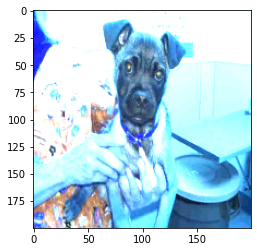

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Cat


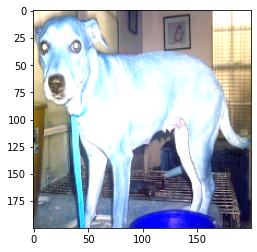

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


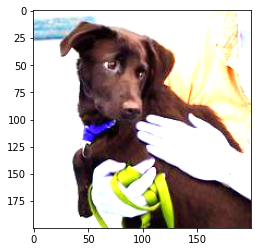

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Cat


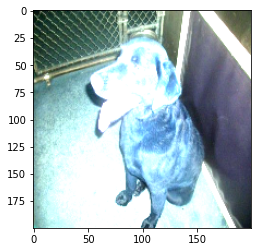

actual_label: Dog predicted_label: Dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


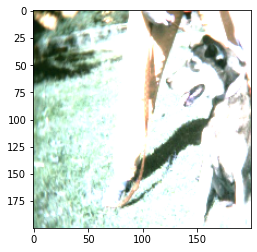

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Cat


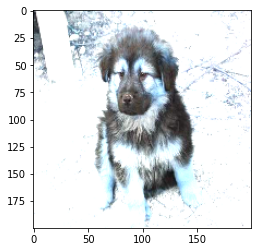

actual_label: Dog predicted_label: Dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


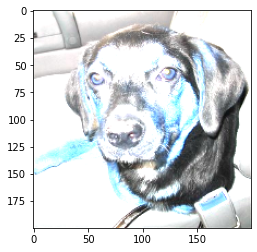

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Cat


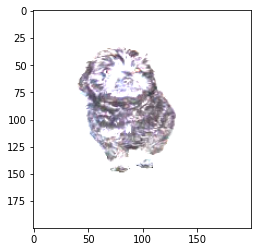

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Cat


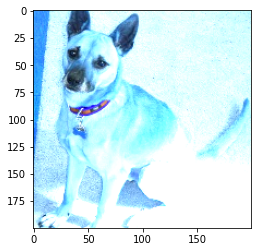

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


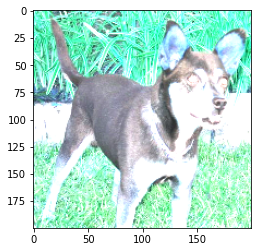


 test accuracy: 63.942307692307686 %


In [240]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)


train_loss = []
validation_loss = []
train_acc = [] 
validation_acc = []

num_epochs = 5
learning_rate = 0.0001

batch_size=64

model = CNN3()
model = model.to(device)

model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=0,weight_decay=1e-4)

for epoch in range(num_epochs):
  running_loss = 0.0
  running_correct = 0
  model.train()
  with tqdm(total=len(trainloader)) as pbar:  
    for idx,batch in enumerate(trainloader):
      imgs,lbls = batch
      imgs = imgs.float()
      lbls = lbls.long()
      
      imgs = imgs.to(device)
      lbls = lbls.to(device)

      optimizer.zero_grad()

      out = model(imgs)
      loss = criterion(out,lbls)

      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      num_correct = torch.sum(torch.argmax(out, dim=1) == lbls).item()

      running_correct += num_correct

      pbar.set_postfix(batch_loss='{}'.format(loss.item()))
      pbar.update(1)      
  
  
  train_loss.append(running_loss/float(len(trainloader)))
  train_acc.append(running_correct/float(len(trainloader)*batch_size))



  print("\nepoch:",epoch," Train Loss:",running_loss/float(len(trainloader))," Train Accuracy:",running_correct/float(len(trainloader)*batch_size))



model.eval()
test_loss,test_acc = test(testloader,model,criterion,purpose="test")
print("\n test accuracy:",test_acc*100,"%")


## Minibatch SGD with momentum

Defaulting to user installation because normal site-packages is not writeable
(15421,)
(15421,)
(6610,)
(6610,)
241
104
cuda


100%|██████████| 241/241 [01:11<00:00,  3.38it/s, batch_loss=1.5391114950180054]



epoch: 0  Train Loss: 1.6727362994831132  Train Accuracy: 0.4845695020746888


100%|██████████| 241/241 [01:11<00:00,  3.37it/s, batch_loss=0.783412754535675] 



epoch: 1  Train Loss: 1.2618758866401134  Train Accuracy: 0.6098936721991701


100%|██████████| 241/241 [01:11<00:00,  3.39it/s, batch_loss=0.586553156375885]  



epoch: 2  Train Loss: 0.6356358228877372  Train Accuracy: 0.6718101659751037


100%|██████████| 241/241 [01:11<00:00,  3.39it/s, batch_loss=0.6433567404747009] 



epoch: 3  Train Loss: 0.5648091868246244  Train Accuracy: 0.7149896265560166


100%|██████████| 241/241 [01:11<00:00,  3.38it/s, batch_loss=0.45827481150627136]



epoch: 4  Train Loss: 0.5201693569228857  Train Accuracy: 0.749027489626556


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


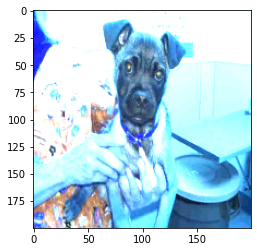

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Cat


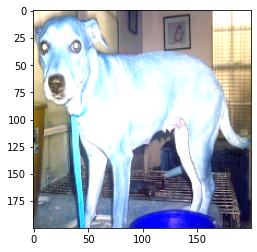

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


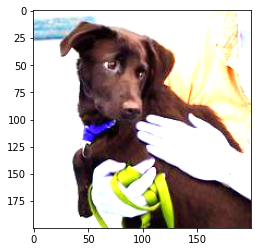

actual_label: Dog predicted_label: Dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


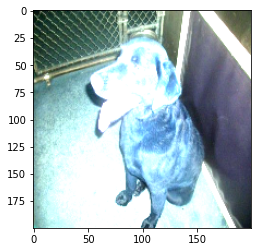

actual_label: Dog predicted_label: Dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


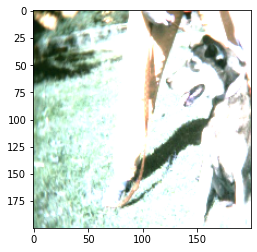

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


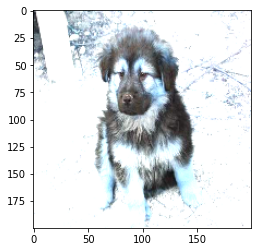

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Cat


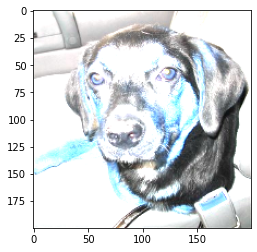

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


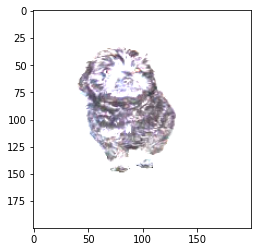

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Cat


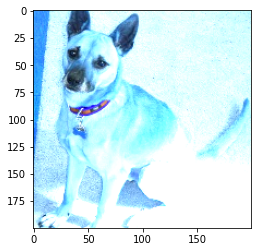

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


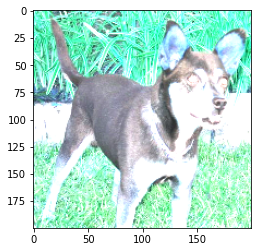


 test accuracy: 75.79627403846155 %


In [2]:
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn
!pip install split-folders[full]
import splitfolders
import cv2
import glob
from torch.utils.data import Dataset,DataLoader


x_train = []
y_train = []

for folder in glob.glob("/content/drive/MyDrive/Cat_Dog/output6/train"+"/*"):
  for file1 in glob.glob(folder+"/*"):
    if folder.split("/")[-1] == 'Cat':
      x_train.append(file1)
      y_train.append(int(0))

    elif folder.split("/")[-1] == 'Dog':
      x_train.append(file1)
      y_train.append(int(1))

x_train = np.array(x_train)
y_train = np.array(y_train)


x_test = []
y_test = []

for folder in glob.glob("/content/drive/MyDrive/Cat_Dog/output6/val"+"/*"):
  for file1 in glob.glob(folder+"/*"):
    if folder.split("/")[-1] == 'Cat':
      x_test.append(file1)
      y_test.append(int(0))

    elif folder.split("/")[-1] == 'Dog':
      x_test.append(file1)
      y_test.append(int(1))

x_test = np.array(x_test)
y_test = np.array(y_test) 

np.save("/content/drive/MyDrive/Cat_Dog/cat_dog_x_train.npy",x_train)
np.save("/content/drive/MyDrive/Cat_Dog/cat_dog_y_train.npy",y_train)
np.save("/content/drive/MyDrive/Cat_Dog/cat_dog_x_test.npy",x_test)
np.save("/content/drive/MyDrive/Cat_Dog/cat_dog_y_test.npy",y_test)

# x_train = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_x_train.npy")
# y_train = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_y_train.npy")
# x_test = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_x_test.npy")
# y_test = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_y_test.npy")

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


class Cat_DOG(Dataset):

  def __init__(self,x_train,y_train,transform=None):

      self.x_train = x_train
      self.y_train = y_train
      self.transform = transform

  def __len__(self):
    return len(self.x_train)

  def __getitem__(self,idx):

    try:
        image = cv2.imread(self.x_train[idx].replace('/content/drive/MyDrive/','/DATA1/Chiranjeev/'))
        image = cv2.resize(image.astype(float),(200,200))
        label = self.y_train[idx]
    except:
        image = cv2.imread(self.x_train[idx-1].replace('/content/drive/MyDrive/','/DATA1/Chiranjeev/'))
        image = cv2.resize(image.astype(float),(200,200))
        label = self.y_train[idx-1]


    if self.transform:     
      image = self.transform(image)

    return image,label


class ToTransform:

  def __call__(self,image):

    trans = transforms.Compose([
                  transforms.ToTensor(),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                  ])
    image = trans(image)

    return image


train_dataset = Cat_DOG(x_train,y_train,transform = ToTransform())
test_dataset = Cat_DOG(x_test,y_test,transform = ToTransform())

batch_size = 64
trainloader = DataLoader(train_dataset,batch_size=batch_size,num_workers = 0, shuffle=True)#,worker_init_fn = np.random.seed(42))
testloader = DataLoader(test_dataset,batch_size=batch_size,num_workers = 0,shuffle=False)


print(len(trainloader))
print(len(testloader))


class CNN3(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv1 = nn.Conv2d(3,16,3)
    self.bn1 = nn.BatchNorm2d(16) 
    self.conv2 = nn.Conv2d(16,32,3)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32,64,5)
    self.bn3 = nn.BatchNorm2d(64)

    self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))
    self.flatten_shape =  64 * 22 * 22
    self.linear1 = nn.Linear(in_features=self.flatten_shape,out_features=32)
    self.linear2 = nn.Linear(in_features=32, out_features=16)
    self.linear3 = nn.Linear(in_features=16, out_features=8)
    self.linear4 = nn.Linear(in_features=8, out_features=2)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d((2,2),stride=2)
    self.dropout = nn.Dropout(0.2)


  
  def forward(self,x):
    
    x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
    x = self.maxpool(self.relu(self.bn2(self.conv2(x))))
    x = self.maxpool(self.relu(self.bn3(self.conv3(x))))

    flat_features = x.reshape(-1, x.shape[1] * x.shape[2] * x.shape[3])
    x=self.dropout(self.linear1(flat_features))
    x=self.relu(self.linear2(x))
    x=self.relu(self.linear3(x))
    x=self.relu(self.linear4(x))
    return x


class_names = ['Cat', 'Dog']
def test(dataloader,model,criterion,purpose="test"):
    batch_size=64
    with torch.no_grad():
        test_loss = 0.0
        test_correct = 0
        for idx,batch in enumerate(dataloader):
            imgs,lbls = batch
            imgs = imgs.float()
            lbls = lbls.long()
            
            imgs = imgs.to(device)
            lbls = lbls.to(device)
            out = model(imgs)
            loss = criterion(out,lbls)

            test_loss += loss.item()
                
            test_pred = torch.argmax(out, dim=1)
            test_correct += torch.sum(test_pred == lbls)
            
        test_loss = test_loss/float(len(dataloader))
        test_acc = float(float(test_correct)/float(len(dataloader)*batch_size))

        if purpose == "test": 
            for idx,batch in enumerate(dataloader):
              imgs,lbls = batch
              imgs = imgs.to(device)
              imgs = imgs.float()
              lbls = lbls.long()
              out = model(imgs)
              test_pred = torch.argmax(out, dim=1)
              for i in range(10,30,2):
                img = imgs[i]
                actual_lbl = lbls[i].detach().cpu().numpy()
                pred_lbl = test_pred[i].detach().cpu().numpy()
                img_disp = img.permute(1,2,0).detach().cpu().numpy()
                actual_lbl_disp = actual_lbl
                pred_lbl_disp = pred_lbl
                print("actual_label:",class_names[actual_lbl_disp],"predicted_label:",class_names[pred_lbl_disp])
                plt.imshow((img_disp/255.0))
                plt.show()
              break
                        
            
    
    return test_loss,test_acc



device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)


train_loss = []
validation_loss = []
train_acc = [] 
validation_acc = []

num_epochs = 5
learning_rate = 0.0001

batch_size=64

model = CNN3()
model = model.to(device)

model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=0.9,weight_decay=1e-4)

for epoch in range(num_epochs):
  running_loss = 0.0
  running_correct = 0
  model.train()
  with tqdm(total=len(trainloader)) as pbar:  
    for idx,batch in enumerate(trainloader):
      imgs,lbls = batch
      imgs = imgs.float()
      lbls = lbls.long()
      
      imgs = imgs.to(device)
      lbls = lbls.to(device)

      optimizer.zero_grad()

      out = model(imgs)
      loss = criterion(out,lbls)

      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      num_correct = torch.sum(torch.argmax(out, dim=1) == lbls).item()

      running_correct += num_correct

      pbar.set_postfix(batch_loss='{}'.format(loss.item()))
      pbar.update(1)      
  
  
  train_loss.append(running_loss/float(len(trainloader)))
  train_acc.append(running_correct/float(len(trainloader)*batch_size))


  print("\nepoch:",epoch," Train Loss:",running_loss/float(len(trainloader))," Train Accuracy:",running_correct/float(len(trainloader)*batch_size),)#" Validation Loss:",val_loss," Validation Accuracy:",val_acc,"\n")



model.eval()
test_loss,test_acc = test(testloader,model,criterion,purpose="test")
print("\n test accuracy:",test_acc*100,"%")







## Minibatch with Adam

You should consider upgrading via the '/home/euclid/venv/torch/bin/python3 -m pip install --upgrade pip' command.
(15421,)
(15421,)
(6610,)
(6610,)
241
104
cuda


  0%|          | 0/241 [00:00<?, ?it/s]/home/euclid/venv/torch/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 241/241 [01:27<00:00,  2.77it/s, batch_loss=0.4889514744281769] 


10425

epoch: 0  Train Loss: 0.5900972955454434  Train Accuracy: 0.6758947095435685


100%|██████████| 241/241 [01:26<00:00,  2.78it/s, batch_loss=0.5363173484802246] 


11779

epoch: 1  Train Loss: 0.4879352629679367  Train Accuracy: 0.763679979253112


100%|██████████| 241/241 [01:27<00:00,  2.76it/s, batch_loss=0.599101722240448]  


12188

epoch: 2  Train Loss: 0.44804335234076154  Train Accuracy: 0.7901970954356846


100%|██████████| 241/241 [01:26<00:00,  2.78it/s, batch_loss=0.3574068248271942] 


12431

epoch: 3  Train Loss: 0.42149937721703556  Train Accuracy: 0.8059517634854771


100%|██████████| 241/241 [01:27<00:00,  2.75it/s, batch_loss=0.4330412745475769] 


12589

epoch: 4  Train Loss: 0.39937308974780483  Train Accuracy: 0.8161955394190872


100%|██████████| 241/241 [01:21<00:00,  2.94it/s, batch_loss=0.3925771415233612] 


12782

epoch: 5  Train Loss: 0.37724121928956994  Train Accuracy: 0.8287085062240664


100%|██████████| 241/241 [01:21<00:00,  2.95it/s, batch_loss=0.3333594501018524] 


12917

epoch: 6  Train Loss: 0.3630965389156737  Train Accuracy: 0.8374610995850622


100%|██████████| 241/241 [01:22<00:00,  2.94it/s, batch_loss=0.37773597240448]   


12998

epoch: 7  Train Loss: 0.35049883279315663  Train Accuracy: 0.8427126556016598


100%|██████████| 241/241 [01:22<00:00,  2.92it/s, batch_loss=0.41137567162513733]


13203

epoch: 8  Train Loss: 0.3291957639930654  Train Accuracy: 0.8560036307053942


100%|██████████| 241/241 [01:22<00:00,  2.93it/s, batch_loss=0.3853205144405365] 


13309

epoch: 9  Train Loss: 0.31673437332216636  Train Accuracy: 0.8628760373443983


100%|██████████| 241/241 [01:22<00:00,  2.92it/s, batch_loss=0.43292486667633057]


13431

epoch: 10  Train Loss: 0.30372671041003896  Train Accuracy: 0.8707857883817427


100%|██████████| 241/241 [01:23<00:00,  2.90it/s, batch_loss=0.33930784463882446]


13497

epoch: 11  Train Loss: 0.2914234612492605  Train Accuracy: 0.8750648340248963


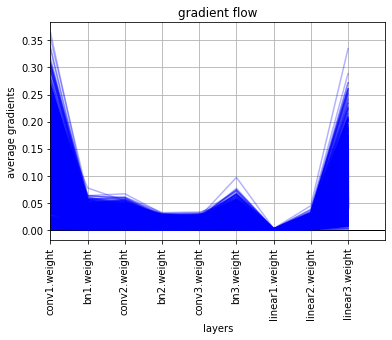

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


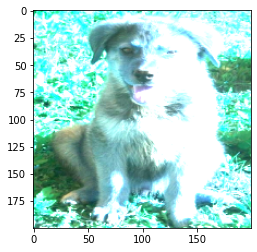

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


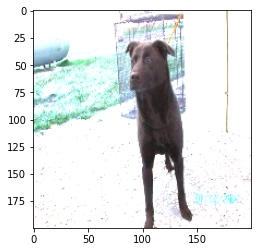

actual_label: Dog predicted_label: Cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


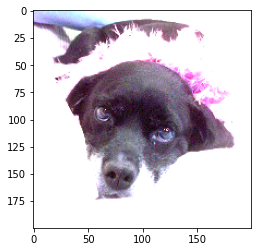

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


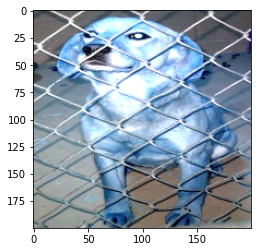

actual_label: Dog predicted_label: Dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


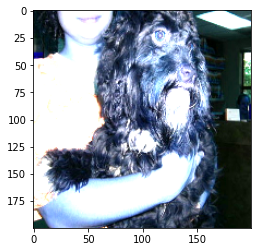

actual_label: Dog predicted_label: Dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


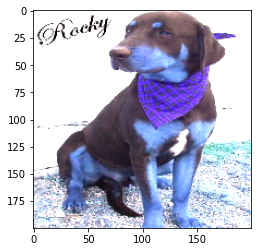

actual_label: Dog predicted_label: Cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


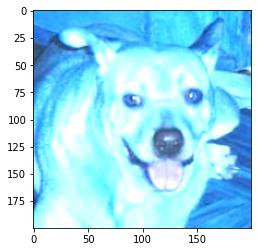

actual_label: Dog predicted_label: Dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


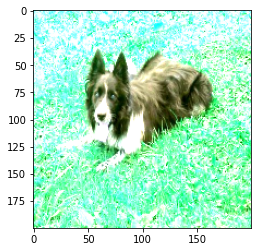

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Cat


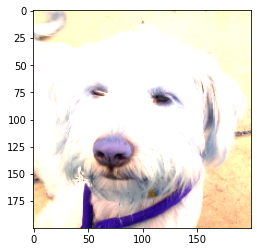

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


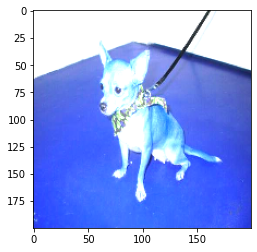


 test accuracy: 82.33173076923077 %


In [1]:

from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn
!pip install split-folders[full]
import splitfolders
import cv2
import glob
from torch.utils.data import Dataset,DataLoader


x_train = []
y_train = []

for folder in glob.glob("/DATA1/Chiranjeev/Cat_Dog/output6/train"+"/*"):
  for file1 in glob.glob(folder+"/*"):
    if folder.split("/")[-1] == 'Cat':
      x_train.append(file1)
      y_train.append(int(0))

    elif folder.split("/")[-1] == 'Dog':
      x_train.append(file1)
      y_train.append(int(1))

x_train = np.array(x_train)
y_train = np.array(y_train)


x_test = []
y_test = []

for folder in glob.glob("/DATA1/Chiranjeev/Cat_Dog/output6/val"+"/*"):
  for file1 in glob.glob(folder+"/*"):
    if folder.split("/")[-1] == 'Cat':
      x_test.append(file1)
      y_test.append(int(0))

    elif folder.split("/")[-1] == 'Dog':
      x_test.append(file1)
      y_test.append(int(1))

x_test = np.array(x_test)
y_test = np.array(y_test) 

np.save("/DATA1/Chiranjeev/Cat_Dog/cat_dog_x_train.npy",x_train)
np.save("/DATA1/Chiranjeev/Cat_Dog/cat_dog_y_train.npy",y_train)
np.save("/DATA1/Chiranjeev/Cat_Dog/cat_dog_x_test.npy",x_test)
np.save("/DATA1/Chiranjeev/Cat_Dog/cat_dog_y_test.npy",y_test)

# x_train = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_x_train.npy")
# y_train = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_y_train.npy")
# x_test = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_x_test.npy")
# y_test = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_y_test.npy")

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


def gradient_update_plot(named_parameters,flag=False):
    avg_gradients = []
    layers = []
    if flag == False:
        for n,p in named_parameters:
            if(p.requires_grad) and ('bias' not in n):
                layers.append(n)
                avg_gradients.append(p.grad.abs().mean())

        plt.plot(avg_gradients,alpha=0.3,color='b')
        plt.hlines(0,0,len(avg_gradients)+1,linewidth=1,color='k')
        plt.xlim(xmin=0,xmax=len(avg_gradients))
        plt.xticks(range(0,len(avg_gradients),1),layers,rotation='vertical')
        plt.xlabel('layers')
        plt.ylabel('average gradients')
        plt.title('gradient flow')
        plt.grid(True)
    if flag==True:
        plt.show()
        
class Cat_DOG(Dataset):

  def __init__(self,x_train,y_train,transform=None):

      self.x_train = x_train
      self.y_train = y_train
      self.transform = transform

  def __len__(self):
    return len(self.x_train)

  def __getitem__(self,idx):

    try:
        image = cv2.imread(self.x_train[idx].replace('/content/drive/MyDrive/','/DATA1/Chiranjeev/'))
        image = cv2.resize(image.astype(float),(200,200))
        label = self.y_train[idx]
    except:
        image = cv2.imread(self.x_train[idx-1].replace('/content/drive/MyDrive/','/DATA1/Chiranjeev/'))
        image = cv2.resize(image.astype(float),(200,200))
        label = self.y_train[idx-1]


    if self.transform:     
      image = self.transform(image)

    return image,label


class ToTransform:

  def __call__(self,image):

    trans = transforms.Compose([
                  transforms.ToTensor(),
                  transforms.RandomHorizontalFlip(),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                  ])
    image = trans(image)

    return image


train_dataset = Cat_DOG(x_train,y_train,transform = ToTransform())
test_dataset = Cat_DOG(x_test,y_test,transform = ToTransform())

batch_size = 64
trainloader = DataLoader(train_dataset,batch_size=batch_size,num_workers = 0, shuffle=True)#,worker_init_fn = np.random.seed(42))
testloader = DataLoader(test_dataset,batch_size=batch_size,num_workers = 0,shuffle=False)


print(len(trainloader))
print(len(testloader))


class CNN3(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv1 = nn.Conv2d(3,16,3)
    self.bn1 = nn.BatchNorm2d(16) 
    self.conv2 = nn.Conv2d(16,32,3)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32,32,3)
    self.bn3 = nn.BatchNorm2d(32)

    self.flatten_shape =  32 * 23 * 23
    self.linear1 = nn.Linear(in_features=self.flatten_shape,out_features=64)
    self.linear2 = nn.Linear(in_features=64, out_features=32)
    self.linear3 = nn.Linear(in_features=32, out_features=2)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d((2,2),stride=2)
    self.dropout = nn.Dropout(0.2)


  
  def forward(self,x):
    
    x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
    x = self.maxpool(self.relu(self.bn2(self.conv2(x))))
    x = self.maxpool(self.relu(self.bn3(self.conv3(x))))


    flat_features = x.reshape(-1, x.shape[1] * x.shape[2] * x.shape[3])
    x=self.dropout(flat_features)
    x=self.relu(self.linear1(x))
    x=self.relu(self.linear2(x))
    x=self.relu(self.linear3(x))

    return x


class_names = ['Cat', 'Dog']
def test(dataloader,model,criterion,purpose="test"):
    with torch.no_grad():
        test_loss = 0.0
        test_correct = 0
        for idx,batch in enumerate(dataloader):
            imgs,lbls = batch
            imgs = imgs.float()
            lbls = lbls.long()
            
            imgs = imgs.to(device)
            lbls = lbls.to(device)
            out = model(imgs)
            loss = criterion(out,lbls)

            test_loss += loss.item()
                
            test_pred = torch.argmax(out, dim=1)
            test_correct += torch.sum(test_pred == lbls)
            
        test_loss = test_loss/float(len(dataloader))
        test_acc = float(float(test_correct)/float(len(dataloader)*batch_size))

        if purpose == "test": 
            for idx,batch in enumerate(dataloader):
              imgs,lbls = batch
              imgs = imgs
              imgs = imgs.float().to(device)
              lbls = lbls.long().to(device)
              out = model(imgs)
              test_pred = torch.argmax(out, dim=1)
              for i in range(10):
                img = imgs[i]
                actual_lbl = lbls[i].detach().cpu().numpy()
                pred_lbl = test_pred[i].detach().cpu().numpy()

                img_disp = img.permute(1,2,0).detach().cpu().numpy()
                actual_lbl_disp = actual_lbl
                pred_lbl_disp = pred_lbl
                print("actual_label:",class_names[actual_lbl_disp],"predicted_label:",class_names[pred_lbl_disp])
                plt.imshow((img_disp/255.0))
                plt.show()
              break
                        
            
    
    return test_loss,test_acc



device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)


train_loss = []
validation_loss = []
train_acc = [] 
validation_acc = []

num_epochs = 12
learning_rate = 0.0001

model = CNN3()
model = model.to(device)

model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-4)



for epoch in range(num_epochs):
  running_loss = 0.0
  running_correct = 0
  model.train()
  with tqdm(total=len(trainloader)) as pbar:  
    for idx,batch in enumerate(trainloader):
      imgs,lbls = batch
      imgs = imgs.float()
      lbls = lbls.long()
      
      imgs = imgs.to(device)
      lbls = lbls.to(device)

      optimizer.zero_grad()

      out = model(imgs)
      loss = criterion(out,lbls)

      loss.backward()
      gradient_update_plot(model.named_parameters())

      optimizer.step()

      running_loss += loss.item()
      num_correct = torch.sum(torch.argmax(out, dim=1) == lbls).item()

      running_correct += num_correct
            
      pbar.set_postfix(batch_loss='{}'.format(loss.item()))
      pbar.update(1)      


  
  train_loss.append(running_loss/float(len(trainloader)))
  train_acc.append(running_correct/float(len(trainloader)*batch_size))
  print(running_correct)

  print("\nepoch:",epoch," Train Loss:",running_loss/len(trainloader)," Train Accuracy:",running_correct/(len(trainloader)*batch_size))#" Validation Loss:",val_loss," Validation Accuracy:",val_acc,"\n")

gradient_update_plot(model.named_parameters(),flag=True)

model.eval()
test_loss,test_acc = test(testloader,model,criterion,purpose="test")
print("\n test accuracy:",test_acc*100,"%")







You should consider upgrading via the '/home/euclid/venv/torch/bin/python3 -m pip install --upgrade pip' command.
(15421,)
(15421,)
(6610,)
(6610,)
482
207
cuda


  0%|          | 0/482 [00:00<?, ?it/s]/home/euclid/venv/torch/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 482/482 [01:28<00:00,  5.46it/s, batch_loss=0.6961011290550232] 


10776

epoch: 0  Train Loss: 0.5667134739798629  Train Accuracy: 0.6986514522821576


100%|██████████| 482/482 [01:24<00:00,  5.70it/s, batch_loss=0.4668712913990021] 


11855

epoch: 1  Train Loss: 0.4766136233180885  Train Accuracy: 0.7686073651452282


100%|██████████| 482/482 [01:29<00:00,  5.37it/s, batch_loss=0.49042296409606934]


12255

epoch: 2  Train Loss: 0.4394586714471524  Train Accuracy: 0.7945409751037344


100%|██████████| 482/482 [01:32<00:00,  5.21it/s, batch_loss=0.34300684928894043]


12475

epoch: 3  Train Loss: 0.4133569440530049  Train Accuracy: 0.8088044605809128


100%|██████████| 482/482 [01:32<00:00,  5.24it/s, batch_loss=0.4031532406806946] 


12624

epoch: 4  Train Loss: 0.39157940716293343  Train Accuracy: 0.8184647302904564


100%|██████████| 482/482 [01:34<00:00,  5.12it/s, batch_loss=0.28737327456474304]


12863

epoch: 5  Train Loss: 0.36909333245511866  Train Accuracy: 0.8339600622406639


100%|██████████| 482/482 [01:31<00:00,  5.25it/s, batch_loss=0.32988664507865906]


12954

epoch: 6  Train Loss: 0.3546939045190811  Train Accuracy: 0.8398599585062241


100%|██████████| 482/482 [01:36<00:00,  4.97it/s, batch_loss=0.20815734565258026]


13083

epoch: 7  Train Loss: 0.342109590645153  Train Accuracy: 0.8482235477178424


100%|██████████| 482/482 [01:36<00:00,  4.99it/s, batch_loss=0.23903582990169525]


13236

epoch: 8  Train Loss: 0.3194908382239678  Train Accuracy: 0.8581431535269709


100%|██████████| 482/482 [01:38<00:00,  4.91it/s, batch_loss=0.164639413356781]  


13381

epoch: 9  Train Loss: 0.30433456664634445  Train Accuracy: 0.8675440871369294


100%|██████████| 482/482 [01:36<00:00,  4.97it/s, batch_loss=0.17970812320709229]


13434

epoch: 10  Train Loss: 0.2967159757661127  Train Accuracy: 0.8709802904564315


100%|██████████| 482/482 [01:37<00:00,  4.96it/s, batch_loss=0.24448032677173615]


13576

epoch: 11  Train Loss: 0.2832392112533581  Train Accuracy: 0.8801867219917012


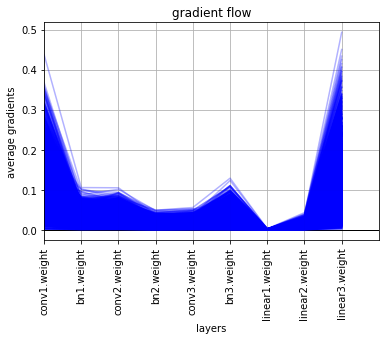

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


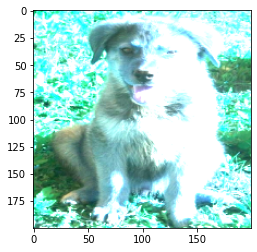

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


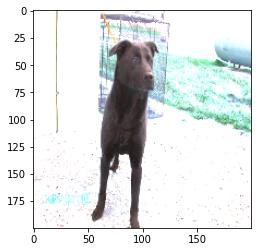

actual_label:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Dog predicted_label: Dog


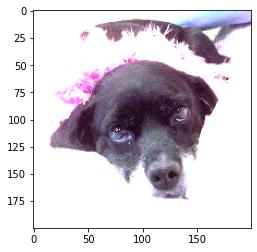

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


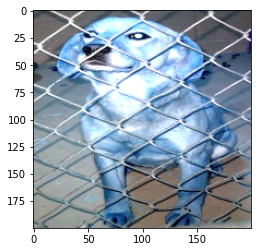

actual_label: Dog predicted_label: Cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


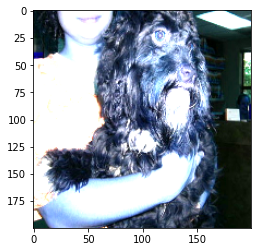

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


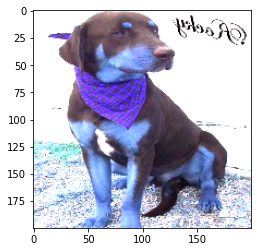

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Cat


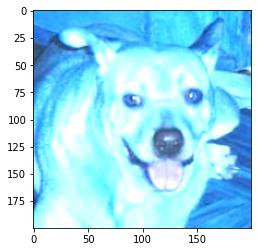

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


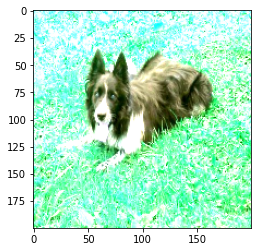

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


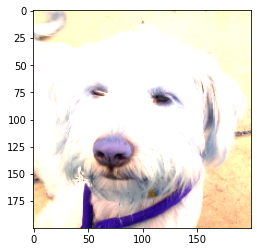

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


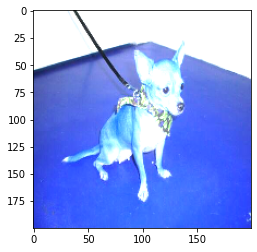


 test accuracy: 81.91425120772948 %


In [1]:

from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn
!pip install split-folders[full]
import splitfolders
import cv2
import glob
from torch.utils.data import Dataset,DataLoader


x_train = []
y_train = []

for folder in glob.glob("/DATA1/Chiranjeev/Cat_Dog/output6/train"+"/*"):
  for file1 in glob.glob(folder+"/*"):
    if folder.split("/")[-1] == 'Cat':
      x_train.append(file1)
      y_train.append(int(0))

    elif folder.split("/")[-1] == 'Dog':
      x_train.append(file1)
      y_train.append(int(1))

x_train = np.array(x_train)
y_train = np.array(y_train)


x_test = []
y_test = []

for folder in glob.glob("/DATA1/Chiranjeev/Cat_Dog/output6/val"+"/*"):
  for file1 in glob.glob(folder+"/*"):
    if folder.split("/")[-1] == 'Cat':
      x_test.append(file1)
      y_test.append(int(0))

    elif folder.split("/")[-1] == 'Dog':
      x_test.append(file1)
      y_test.append(int(1))

x_test = np.array(x_test)
y_test = np.array(y_test) 

np.save("/DATA1/Chiranjeev/Cat_Dog/cat_dog_x_train.npy",x_train)
np.save("/DATA1/Chiranjeev/Cat_Dog/cat_dog_y_train.npy",y_train)
np.save("/DATA1/Chiranjeev/Cat_Dog/cat_dog_x_test.npy",x_test)
np.save("/DATA1/Chiranjeev/Cat_Dog/cat_dog_y_test.npy",y_test)

# x_train = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_x_train.npy")
# y_train = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_y_train.npy")
# x_test = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_x_test.npy")
# y_test = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_y_test.npy")

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


def gradient_update_plot(named_parameters,flag=False):
    avg_gradients = []
    layers = []
    if flag == False:
        for n,p in named_parameters:
            if(p.requires_grad) and ('bias' not in n):
                layers.append(n)
                avg_gradients.append(p.grad.abs().mean())

        plt.plot(avg_gradients,alpha=0.3,color='b')
        plt.hlines(0,0,len(avg_gradients)+1,linewidth=1,color='k')
        plt.xlim(xmin=0,xmax=len(avg_gradients))
        plt.xticks(range(0,len(avg_gradients),1),layers,rotation='vertical')
        plt.xlabel('layers')
        plt.ylabel('average gradients')
        plt.title('gradient flow')
        plt.grid(True)
    if flag==True:
        plt.show()
        
class Cat_DOG(Dataset):

  def __init__(self,x_train,y_train,transform=None):

      self.x_train = x_train
      self.y_train = y_train
      self.transform = transform

  def __len__(self):
    return len(self.x_train)

  def __getitem__(self,idx):

    try:
        image = cv2.imread(self.x_train[idx].replace('/content/drive/MyDrive/','/DATA1/Chiranjeev/'))
        image = cv2.resize(image.astype(float),(200,200))
        label = self.y_train[idx]
    except:
        image = cv2.imread(self.x_train[idx-1].replace('/content/drive/MyDrive/','/DATA1/Chiranjeev/'))
        image = cv2.resize(image.astype(float),(200,200))
        label = self.y_train[idx-1]


    if self.transform:     
      image = self.transform(image)

    return image,label


class ToTransform:

  def __call__(self,image):

    trans = transforms.Compose([
                  transforms.ToTensor(),
                  transforms.RandomHorizontalFlip(),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                  ])
    image = trans(image)

    return image


train_dataset = Cat_DOG(x_train,y_train,transform = ToTransform())
test_dataset = Cat_DOG(x_test,y_test,transform = ToTransform())

batch_size = 32
trainloader = DataLoader(train_dataset,batch_size=batch_size,num_workers = 0, shuffle=True)#,worker_init_fn = np.random.seed(42))
testloader = DataLoader(test_dataset,batch_size=batch_size,num_workers = 0,shuffle=False)


print(len(trainloader))
print(len(testloader))


class CNN3(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv1 = nn.Conv2d(3,16,3)
    self.bn1 = nn.BatchNorm2d(16) 
    self.conv2 = nn.Conv2d(16,32,3)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32,32,3)
    self.bn3 = nn.BatchNorm2d(32)

    self.flatten_shape =  32 * 23 * 23
    self.linear1 = nn.Linear(in_features=self.flatten_shape,out_features=64)
    self.linear2 = nn.Linear(in_features=64, out_features=32)
    self.linear3 = nn.Linear(in_features=32, out_features=2)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d((2,2),stride=2)
    self.dropout = nn.Dropout(0.2)


  
  def forward(self,x):
    
    x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
    x = self.maxpool(self.relu(self.bn2(self.conv2(x))))
    x = self.maxpool(self.relu(self.bn3(self.conv3(x))))

    flat_features = x.reshape(-1, x.shape[1] * x.shape[2] * x.shape[3])
    x=self.dropout(flat_features)
    x=self.relu(self.linear1(x))
    x=self.relu(self.linear2(x))
    x=self.relu(self.linear3(x))


    return x


class_names = ['Cat', 'Dog']
def test(dataloader,model,criterion,purpose="test"):
    with torch.no_grad():
        test_loss = 0.0
        test_correct = 0
        for idx,batch in enumerate(dataloader):
            imgs,lbls = batch
            imgs = imgs.float()
            lbls = lbls.long()
            
            imgs = imgs.to(device)
            lbls = lbls.to(device)
            out = model(imgs)
            loss = criterion(out,lbls)

            test_loss += loss.item()
                
            test_pred = torch.argmax(out, dim=1)
            test_correct += torch.sum(test_pred == lbls)
            
        test_loss = test_loss/float(len(dataloader))
        test_acc = float(float(test_correct)/float(len(dataloader)*batch_size))

        if purpose == "test": 
            for idx,batch in enumerate(dataloader):
              imgs,lbls = batch
              imgs = imgs
              imgs = imgs.float().to(device)
              lbls = lbls.long().to(device)
              out = model(imgs)
              test_pred = torch.argmax(out, dim=1)
              for i in range(10):
                img = imgs[i]
                actual_lbl = lbls[i].detach().cpu().numpy()
                pred_lbl = test_pred[i].detach().cpu().numpy()

                img_disp = img.permute(1,2,0).detach().cpu().numpy()
                actual_lbl_disp = actual_lbl
                pred_lbl_disp = pred_lbl
                print("actual_label:",class_names[actual_lbl_disp],"predicted_label:",class_names[pred_lbl_disp])
                plt.imshow((img_disp/255.0))
                plt.show()
              break
                        
            
    
    return test_loss,test_acc



device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)


train_loss = []
validation_loss = []
train_acc = [] 
validation_acc = []

num_epochs = 12
learning_rate = 0.0001

model = CNN3()
model = model.to(device)

model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-4)



for epoch in range(num_epochs):
  running_loss = 0.0
  running_correct = 0
  model.train()
  with tqdm(total=len(trainloader)) as pbar:  
    for idx,batch in enumerate(trainloader):
      imgs,lbls = batch
      imgs = imgs.float()
      lbls = lbls.long()
      
      imgs = imgs.to(device)
      lbls = lbls.to(device)

      optimizer.zero_grad()

      out = model(imgs)
      loss = criterion(out,lbls)

      loss.backward()
      gradient_update_plot(model.named_parameters())

      optimizer.step()

      running_loss += loss.item()
      num_correct = torch.sum(torch.argmax(out, dim=1) == lbls).item()

      running_correct += num_correct

      pbar.set_postfix(batch_loss='{}'.format(loss.item()))
      pbar.update(1)      

  
  train_loss.append(running_loss/float(len(trainloader)))
  train_acc.append(running_correct/float(len(trainloader)*batch_size))
  print(running_correct)

  print("\nepoch:",epoch," Train Loss:",running_loss/len(trainloader)," Train Accuracy:",running_correct/(len(trainloader)*batch_size))#" Validation Loss:",val_loss," Validation Accuracy:",val_acc,"\n")

gradient_update_plot(model.named_parameters(),flag=True)

model.eval()
test_loss,test_acc = test(testloader,model,criterion,purpose="test")
print("\n test accuracy:",test_acc*100,"%")







You should consider upgrading via the '/home/euclid/venv/torch/bin/python3 -m pip install --upgrade pip' command.
(15421,)
(15421,)
(6610,)
(6610,)
964
414
cuda


  0%|          | 0/964 [00:00<?, ?it/s]/home/euclid/venv/torch/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 964/964 [01:29<00:00, 10.78it/s, batch_loss=0.40670743584632874]


10248

epoch: 0  Train Loss: 0.5807938758453888  Train Accuracy: 0.6644190871369294


100%|██████████| 964/964 [01:33<00:00, 10.27it/s, batch_loss=0.4989432096481323] 


11830

epoch: 1  Train Loss: 0.4790255471105645  Train Accuracy: 0.7669865145228216


100%|██████████| 964/964 [01:37<00:00,  9.88it/s, batch_loss=0.5196764469146729] 


12344

epoch: 2  Train Loss: 0.43427012111079644  Train Accuracy: 0.8003112033195021


100%|██████████| 964/964 [01:44<00:00,  9.25it/s, batch_loss=0.3690797984600067] 


12651

epoch: 3  Train Loss: 0.4006319968686806  Train Accuracy: 0.8202152489626556


100%|██████████| 964/964 [01:47<00:00,  8.98it/s, batch_loss=0.5800657868385315] 


12775

epoch: 4  Train Loss: 0.38384492710016327  Train Accuracy: 0.8282546680497925


100%|██████████| 964/964 [01:51<00:00,  8.68it/s, batch_loss=0.7824406027793884] 


12902

epoch: 5  Train Loss: 0.36630930728375666  Train Accuracy: 0.8364885892116183


100%|██████████| 964/964 [01:53<00:00,  8.48it/s, batch_loss=0.21967408061027527]


13033

epoch: 6  Train Loss: 0.3499320853903457  Train Accuracy: 0.8449818464730291


100%|██████████| 964/964 [01:57<00:00,  8.20it/s, batch_loss=0.44890668988227844]


13087

epoch: 7  Train Loss: 0.3447587156119559  Train Accuracy: 0.8484828838174274


100%|██████████| 964/964 [02:01<00:00,  7.90it/s, batch_loss=0.4554399251937866] 


13174

epoch: 8  Train Loss: 0.3289315511715981  Train Accuracy: 0.8541234439834025


100%|██████████| 964/964 [02:04<00:00,  7.72it/s, batch_loss=0.1882772445678711]  


13255

epoch: 9  Train Loss: 0.31963270833074303  Train Accuracy: 0.859375


100%|██████████| 964/964 [02:08<00:00,  7.52it/s, batch_loss=0.3785405158996582] 


13339

epoch: 10  Train Loss: 0.30664434934738266  Train Accuracy: 0.8648210580912863


100%|██████████| 964/964 [02:11<00:00,  7.32it/s, batch_loss=0.5383816957473755]  


13457

epoch: 11  Train Loss: 0.29260135106974244  Train Accuracy: 0.8724714730290456


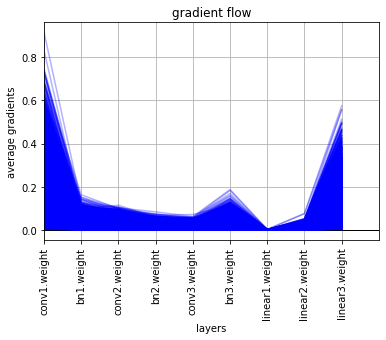

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


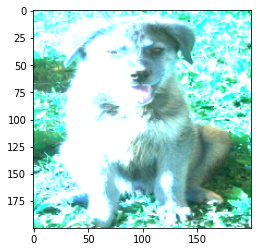

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


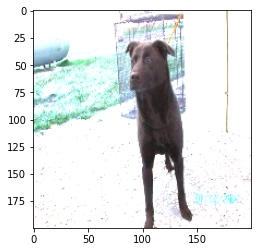

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Cat


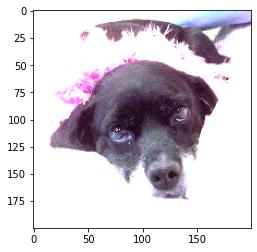

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


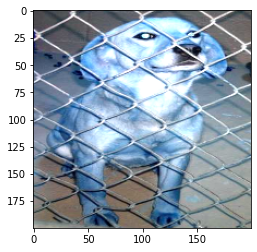

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Cat


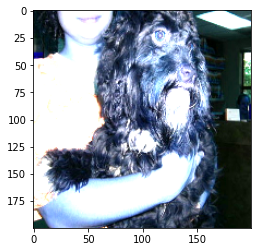

actual_label: Dog predicted_label: Dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


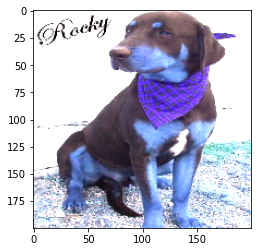

actual_label: Dog predicted_label: Cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


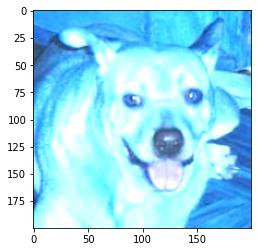

actual_label: Dog predicted_label: Dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


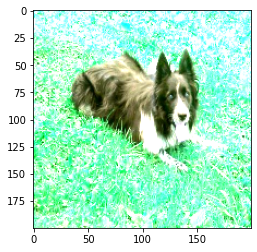

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


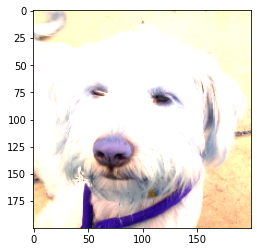

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Cat


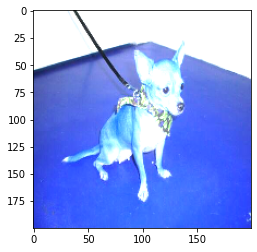


 test accuracy: 82.85024154589372 %


In [1]:

from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn
!pip install split-folders[full]
import splitfolders
import cv2
import glob
from torch.utils.data import Dataset,DataLoader


x_train = []
y_train = []

for folder in glob.glob("/DATA1/Chiranjeev/Cat_Dog/output6/train"+"/*"):
  for file1 in glob.glob(folder+"/*"):
    if folder.split("/")[-1] == 'Cat':
      x_train.append(file1)
      y_train.append(int(0))

    elif folder.split("/")[-1] == 'Dog':
      x_train.append(file1)
      y_train.append(int(1))

x_train = np.array(x_train)
y_train = np.array(y_train)


x_test = []
y_test = []

for folder in glob.glob("/DATA1/Chiranjeev/Cat_Dog/output6/val"+"/*"):
  for file1 in glob.glob(folder+"/*"):
    if folder.split("/")[-1] == 'Cat':
      x_test.append(file1)
      y_test.append(int(0))

    elif folder.split("/")[-1] == 'Dog':
      x_test.append(file1)
      y_test.append(int(1))

x_test = np.array(x_test)
y_test = np.array(y_test) 

np.save("/DATA1/Chiranjeev/Cat_Dog/cat_dog_x_train.npy",x_train)
np.save("/DATA1/Chiranjeev/Cat_Dog/cat_dog_y_train.npy",y_train)
np.save("/DATA1/Chiranjeev/Cat_Dog/cat_dog_x_test.npy",x_test)
np.save("/DATA1/Chiranjeev/Cat_Dog/cat_dog_y_test.npy",y_test)

# x_train = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_x_train.npy")
# y_train = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_y_train.npy")
# x_test = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_x_test.npy")
# y_test = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_y_test.npy")

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


def gradient_update_plot(named_parameters,flag=False):
    avg_gradients = []
    layers = []
    if flag == False:
        for n,p in named_parameters:
            if(p.requires_grad) and ('bias' not in n):
                layers.append(n)
                avg_gradients.append(p.grad.abs().mean())

        plt.plot(avg_gradients,alpha=0.3,color='b')
        plt.hlines(0,0,len(avg_gradients)+1,linewidth=1,color='k')
        plt.xlim(xmin=0,xmax=len(avg_gradients))
        plt.xticks(range(0,len(avg_gradients),1),layers,rotation='vertical')
        plt.xlabel('layers')
        plt.ylabel('average gradients')
        plt.title('gradient flow')
        plt.grid(True)
    if flag==True:
        plt.show()
        
class Cat_DOG(Dataset):

  def __init__(self,x_train,y_train,transform=None):

      self.x_train = x_train
      self.y_train = y_train
      self.transform = transform

  def __len__(self):
    return len(self.x_train)

  def __getitem__(self,idx):

    try:
        image = cv2.imread(self.x_train[idx].replace('/content/drive/MyDrive/','/DATA1/Chiranjeev/'))
        image = cv2.resize(image.astype(float),(200,200))
        label = self.y_train[idx]
    except:
        image = cv2.imread(self.x_train[idx-1].replace('/content/drive/MyDrive/','/DATA1/Chiranjeev/'))
        image = cv2.resize(image.astype(float),(200,200))
        label = self.y_train[idx-1]


    if self.transform:     
      image = self.transform(image)

    return image,label


class ToTransform:

  def __call__(self,image):

    trans = transforms.Compose([
                  transforms.ToTensor(),
                  transforms.RandomHorizontalFlip(),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                  ])
    image = trans(image)

    return image


train_dataset = Cat_DOG(x_train,y_train,transform = ToTransform())
test_dataset = Cat_DOG(x_test,y_test,transform = ToTransform())

batch_size = 16
trainloader = DataLoader(train_dataset,batch_size=batch_size,num_workers = 0, shuffle=True)#,worker_init_fn = np.random.seed(42))
testloader = DataLoader(test_dataset,batch_size=batch_size,num_workers = 0,shuffle=False)


print(len(trainloader))
print(len(testloader))


class CNN3(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv1 = nn.Conv2d(3,16,3)
    self.bn1 = nn.BatchNorm2d(16) 
    self.conv2 = nn.Conv2d(16,32,3)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32,32,3)
    self.bn3 = nn.BatchNorm2d(32)

    self.flatten_shape =  32 * 23 * 23
    self.linear1 = nn.Linear(in_features=self.flatten_shape,out_features=64)
    self.linear2 = nn.Linear(in_features=64, out_features=32)
    self.linear3 = nn.Linear(in_features=32, out_features=2)

    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d((2,2),stride=2)
    self.dropout = nn.Dropout(0.2)


  
  def forward(self,x):
    
    x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
    x = self.maxpool(self.relu(self.bn2(self.conv2(x))))
    x = self.maxpool(self.relu(self.bn3(self.conv3(x))))

    flat_features = x.reshape(-1, x.shape[1] * x.shape[2] * x.shape[3])
    x=self.dropout(flat_features)
    x=self.relu(self.linear1(x))
    x=self.relu(self.linear2(x))
    x=self.relu(self.linear3(x))

    return x


class_names = ['Cat', 'Dog']
def test(dataloader,model,criterion,purpose="test"):
    with torch.no_grad():
        test_loss = 0.0
        test_correct = 0
        for idx,batch in enumerate(dataloader):
            imgs,lbls = batch
            imgs = imgs.float()
            lbls = lbls.long()
            
            imgs = imgs.to(device)
            lbls = lbls.to(device)
            out = model(imgs)
            loss = criterion(out,lbls)

            test_loss += loss.item()
                
            test_pred = torch.argmax(out, dim=1)
            test_correct += torch.sum(test_pred == lbls)
            
        test_loss = test_loss/float(len(dataloader))
        test_acc = float(float(test_correct)/float(len(dataloader)*batch_size))

        if purpose == "test": 
            for idx,batch in enumerate(dataloader):
              imgs,lbls = batch
              imgs = imgs
              imgs = imgs.float().to(device)
              lbls = lbls.long().to(device)
              out = model(imgs)
              test_pred = torch.argmax(out, dim=1)
              for i in range(10):
                img = imgs[i]
                actual_lbl = lbls[i].detach().cpu().numpy()
                pred_lbl = test_pred[i].detach().cpu().numpy()

                img_disp = img.permute(1,2,0).detach().cpu().numpy()
                actual_lbl_disp = actual_lbl
                pred_lbl_disp = pred_lbl
                print("actual_label:",class_names[actual_lbl_disp],"predicted_label:",class_names[pred_lbl_disp])
                plt.imshow((img_disp/255.0))
                plt.show()
              break
                        
            
    
    return test_loss,test_acc



device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)


train_loss = []
validation_loss = []
train_acc = [] 
validation_acc = []

num_epochs = 12
learning_rate = 0.0001

model = CNN3()
model = model.to(device)

model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-4)



for epoch in range(num_epochs):
  running_loss = 0.0
  running_correct = 0
  model.train()
  with tqdm(total=len(trainloader)) as pbar:  
    for idx,batch in enumerate(trainloader):
      imgs,lbls = batch
      imgs = imgs.float()
      lbls = lbls.long()
      
      imgs = imgs.to(device)
      lbls = lbls.to(device)

      optimizer.zero_grad()

      out = model(imgs)
      loss = criterion(out,lbls)

      loss.backward()
      gradient_update_plot(model.named_parameters())

      optimizer.step()

      running_loss += loss.item()
      num_correct = torch.sum(torch.argmax(out, dim=1) == lbls).item()

      running_correct += num_correct

            
      pbar.set_postfix(batch_loss='{}'.format(loss.item()))
      pbar.update(1)      

  
  train_loss.append(running_loss/float(len(trainloader)))
  train_acc.append(running_correct/float(len(trainloader)*batch_size))
  print(running_correct)

  print("\nepoch:",epoch," Train Loss:",running_loss/len(trainloader)," Train Accuracy:",running_correct/(len(trainloader)*batch_size))#" Validation Loss:",val_loss," Validation Accuracy:",val_acc,"\n")

gradient_update_plot(model.named_parameters(),flag=True)

model.eval()
test_loss,test_acc = test(testloader,model,criterion,purpose="test")
print("\n test accuracy:",test_acc*100,"%")







## varying betas 

## betas - (0.2,0.2)

You should consider upgrading via the '/home/euclid/venv/torch/bin/python3 -m pip install --upgrade pip' command.
(15421,)
(15421,)
(6610,)
(6610,)
964
414
cuda


  0%|          | 0/964 [00:00<?, ?it/s]/home/euclid/venv/torch/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 964/964 [01:29<00:00, 10.80it/s, batch_loss=0.48181694746017456]


10712

epoch: 0  Train Loss: 0.5820470498217833  Train Accuracy: 0.6945020746887967


100%|██████████| 964/964 [01:34<00:00, 10.25it/s, batch_loss=0.32320451736450195]


11747

epoch: 1  Train Loss: 0.4993044461328459  Train Accuracy: 0.7616052904564315


100%|██████████| 964/964 [01:39<00:00,  9.72it/s, batch_loss=0.2775406539440155] 


12035

epoch: 2  Train Loss: 0.4683783456173057  Train Accuracy: 0.780277489626556


100%|██████████| 964/964 [01:44<00:00,  9.26it/s, batch_loss=0.3931475877761841] 


12334

epoch: 3  Train Loss: 0.44354109271309683  Train Accuracy: 0.7996628630705395


100%|██████████| 964/964 [01:49<00:00,  8.83it/s, batch_loss=0.584348738193512]  


12452

epoch: 4  Train Loss: 0.4239405808947146  Train Accuracy: 0.8073132780082988


100%|██████████| 964/964 [01:51<00:00,  8.68it/s, batch_loss=0.30096131563186646]


12634

epoch: 5  Train Loss: 0.40597701510916856  Train Accuracy: 0.8191130705394191


100%|██████████| 964/964 [01:53<00:00,  8.48it/s, batch_loss=0.56767338514328]    


12700

epoch: 6  Train Loss: 0.3915525315758382  Train Accuracy: 0.8233921161825726


100%|██████████| 964/964 [01:58<00:00,  8.16it/s, batch_loss=0.8132607936859131] 


12819

epoch: 7  Train Loss: 0.38164352916212  Train Accuracy: 0.8311073651452282


100%|██████████| 964/964 [02:01<00:00,  7.92it/s, batch_loss=0.3026735484600067] 


12932

epoch: 8  Train Loss: 0.371775362335331  Train Accuracy: 0.8384336099585062


100%|██████████| 964/964 [02:03<00:00,  7.81it/s, batch_loss=0.14214105904102325] 


13023

epoch: 9  Train Loss: 0.36308065570380804  Train Accuracy: 0.8443335062240664


100%|██████████| 964/964 [02:07<00:00,  7.58it/s, batch_loss=0.4067668914794922] 


13069

epoch: 10  Train Loss: 0.3570456746965647  Train Accuracy: 0.8473158713692946


100%|██████████| 964/964 [02:10<00:00,  7.38it/s, batch_loss=1.0674030780792236]  


13203

epoch: 11  Train Loss: 0.3429207524933941  Train Accuracy: 0.8560036307053942


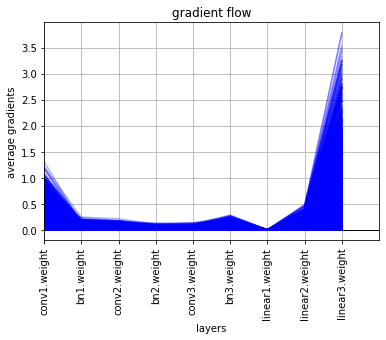

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


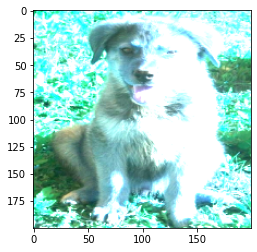

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


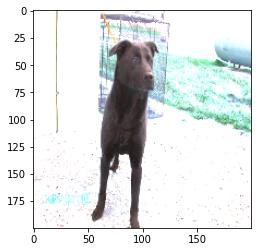

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Cat


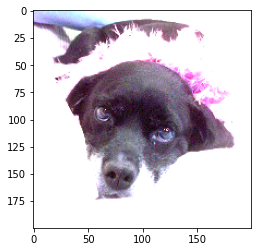

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


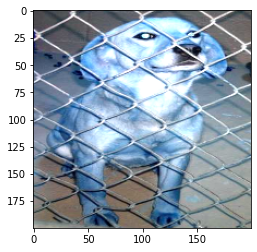

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Cat


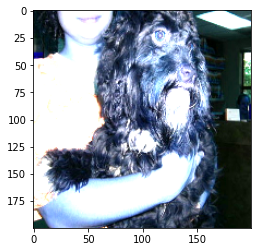

actual_label: Dog predicted_label: Dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


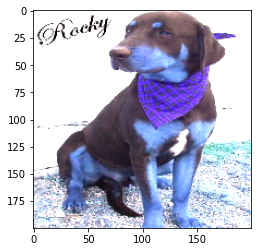

actual_label: Dog predicted_label: Cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


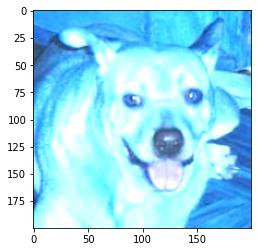

actual_label: Dog predicted_label: Dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


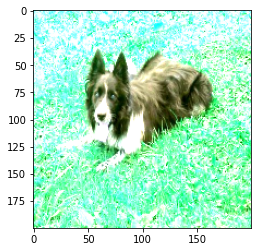

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Cat


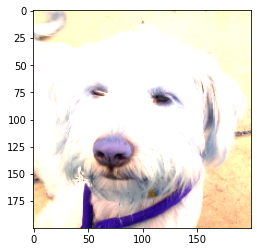

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Cat


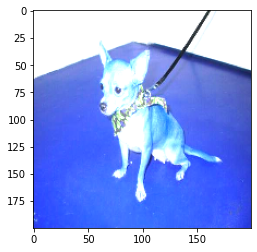


 test accuracy: 81.41606280193237 %


In [1]:

from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn
!pip install split-folders[full]
import splitfolders
import cv2
import glob
from torch.utils.data import Dataset,DataLoader


x_train = []
y_train = []

for folder in glob.glob("/DATA1/Chiranjeev/Cat_Dog/output6/train"+"/*"):
  for file1 in glob.glob(folder+"/*"):
    if folder.split("/")[-1] == 'Cat':
      x_train.append(file1)
      y_train.append(int(0))

    elif folder.split("/")[-1] == 'Dog':
      x_train.append(file1)
      y_train.append(int(1))

x_train = np.array(x_train)
y_train = np.array(y_train)


x_test = []
y_test = []

for folder in glob.glob("/DATA1/Chiranjeev/Cat_Dog/output6/val"+"/*"):
  for file1 in glob.glob(folder+"/*"):
    if folder.split("/")[-1] == 'Cat':
      x_test.append(file1)
      y_test.append(int(0))

    elif folder.split("/")[-1] == 'Dog':
      x_test.append(file1)
      y_test.append(int(1))

x_test = np.array(x_test)
y_test = np.array(y_test) 

np.save("/DATA1/Chiranjeev/Cat_Dog/cat_dog_x_train.npy",x_train)
np.save("/DATA1/Chiranjeev/Cat_Dog/cat_dog_y_train.npy",y_train)
np.save("/DATA1/Chiranjeev/Cat_Dog/cat_dog_x_test.npy",x_test)
np.save("/DATA1/Chiranjeev/Cat_Dog/cat_dog_y_test.npy",y_test)

# x_train = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_x_train.npy")
# y_train = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_y_train.npy")
# x_test = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_x_test.npy")
# y_test = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_y_test.npy")

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


def gradient_update_plot(named_parameters,flag=False):
    avg_gradients = []
    layers = []
    if flag == False:
        for n,p in named_parameters:
            if(p.requires_grad) and ('bias' not in n):
                layers.append(n)
                avg_gradients.append(p.grad.abs().mean())

        plt.plot(avg_gradients,alpha=0.3,color='b')
        plt.hlines(0,0,len(avg_gradients)+1,linewidth=1,color='k')
        plt.xlim(xmin=0,xmax=len(avg_gradients))
        plt.xticks(range(0,len(avg_gradients),1),layers,rotation='vertical')
        plt.xlabel('layers')
        plt.ylabel('average gradients')
        plt.title('gradient flow')
        plt.grid(True)
    if flag==True:
        plt.show()
        
class Cat_DOG(Dataset):

  def __init__(self,x_train,y_train,transform=None):

      self.x_train = x_train
      self.y_train = y_train
      self.transform = transform

  def __len__(self):
    return len(self.x_train)

  def __getitem__(self,idx):

    try:
        image = cv2.imread(self.x_train[idx].replace('/content/drive/MyDrive/','/DATA1/Chiranjeev/'))
        image = cv2.resize(image.astype(float),(200,200))
        label = self.y_train[idx]
    except:
        image = cv2.imread(self.x_train[idx-1].replace('/content/drive/MyDrive/','/DATA1/Chiranjeev/'))
        image = cv2.resize(image.astype(float),(200,200))
        label = self.y_train[idx-1]


    if self.transform:     
      image = self.transform(image)

    return image,label


class ToTransform:

  def __call__(self,image):

    trans = transforms.Compose([
                  transforms.ToTensor(),
                  transforms.RandomHorizontalFlip(),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                  ])
    image = trans(image)

    return image


train_dataset = Cat_DOG(x_train,y_train,transform = ToTransform())
test_dataset = Cat_DOG(x_test,y_test,transform = ToTransform())

batch_size = 16
trainloader = DataLoader(train_dataset,batch_size=batch_size,num_workers = 0, shuffle=True)#,worker_init_fn = np.random.seed(42))
testloader = DataLoader(test_dataset,batch_size=batch_size,num_workers = 0,shuffle=False)


print(len(trainloader))
print(len(testloader))


class CNN3(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv1 = nn.Conv2d(3,16,3)
    self.bn1 = nn.BatchNorm2d(16) 
    self.conv2 = nn.Conv2d(16,32,3)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32,32,3)
    self.bn3 = nn.BatchNorm2d(32)

    self.flatten_shape =  32 * 23 * 23
    self.linear1 = nn.Linear(in_features=self.flatten_shape,out_features=64)
    self.linear2 = nn.Linear(in_features=64, out_features=32)
    self.linear3 = nn.Linear(in_features=32, out_features=2)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d((2,2),stride=2)
    self.dropout = nn.Dropout(0.2)


  
  def forward(self,x):
    
    x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
    x = self.maxpool(self.relu(self.bn2(self.conv2(x))))
    x = self.maxpool(self.relu(self.bn3(self.conv3(x))))

    flat_features = x.reshape(-1, x.shape[1] * x.shape[2] * x.shape[3])
    x=self.dropout(flat_features)
    x=self.relu(self.linear1(x))
    x=self.relu(self.linear2(x))
    x=self.relu(self.linear3(x))

    return x


class_names = ['Cat', 'Dog']
def test(dataloader,model,criterion,purpose="test"):
    with torch.no_grad():
        test_loss = 0.0
        test_correct = 0
        for idx,batch in enumerate(dataloader):
            imgs,lbls = batch
            imgs = imgs.float()
            lbls = lbls.long()
            
            imgs = imgs.to(device)
            lbls = lbls.to(device)
            out = model(imgs)
            loss = criterion(out,lbls)

            test_loss += loss.item()
                
            test_pred = torch.argmax(out, dim=1)
            test_correct += torch.sum(test_pred == lbls)
            
        test_loss = test_loss/float(len(dataloader))
        test_acc = float(float(test_correct)/float(len(dataloader)*batch_size))

        if purpose == "test": 
            for idx,batch in enumerate(dataloader):
              imgs,lbls = batch
              imgs = imgs
              imgs = imgs.float().to(device)
              lbls = lbls.long().to(device)
              out = model(imgs)
              test_pred = torch.argmax(out, dim=1)
              for i in range(10):
                img = imgs[i]
                actual_lbl = lbls[i].detach().cpu().numpy()
                pred_lbl = test_pred[i].detach().cpu().numpy()

                img_disp = img.permute(1,2,0).detach().cpu().numpy()
                actual_lbl_disp = actual_lbl
                pred_lbl_disp = pred_lbl
                print("actual_label:",class_names[actual_lbl_disp],"predicted_label:",class_names[pred_lbl_disp])
                plt.imshow((img_disp/255.0))
                plt.show()
              break
                        
            
    
    return test_loss,test_acc



device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)


train_loss = []
validation_loss = []
train_acc = [] 
validation_acc = []

num_epochs = 12
learning_rate = 0.0001

model = CNN3()
model = model.to(device)

model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),betas=(0.2, 0.2),lr=learning_rate,weight_decay=1e-4)



for epoch in range(num_epochs):
  running_loss = 0.0
  running_correct = 0
  model.train()
  with tqdm(total=len(trainloader)) as pbar:  
    for idx,batch in enumerate(trainloader):
      imgs,lbls = batch
      imgs = imgs.float()
      lbls = lbls.long()
      
      imgs = imgs.to(device)
      lbls = lbls.to(device)

      optimizer.zero_grad()

      out = model(imgs)
      loss = criterion(out,lbls)

      loss.backward()
      gradient_update_plot(model.named_parameters())

      optimizer.step()

      running_loss += loss.item()
      num_correct = torch.sum(torch.argmax(out, dim=1) == lbls).item()

      running_correct += num_correct
            
      pbar.set_postfix(batch_loss='{}'.format(loss.item()))
      pbar.update(1)      

  
  train_loss.append(running_loss/float(len(trainloader)))
  train_acc.append(running_correct/float(len(trainloader)*batch_size))
  print(running_correct)

  print("\nepoch:",epoch," Train Loss:",running_loss/len(trainloader)," Train Accuracy:",running_correct/(len(trainloader)*batch_size))#" Validation Loss:",val_loss," Validation Accuracy:",val_acc,"\n")

gradient_update_plot(model.named_parameters(),flag=True)

model.eval()
test_loss,test_acc = test(testloader,model,criterion,purpose="test")
print("\n test accuracy:",test_acc*100,"%")







## betas - (0.0,0.0) 

You should consider upgrading via the '/home/euclid/venv/torch/bin/python3 -m pip install --upgrade pip' command.
(15421,)
(15421,)
(6610,)
(6610,)
964
414
cuda


100%|██████████| 964/964 [01:31<00:00, 10.49it/s, batch_loss=0.6571177244186401] 


10587

epoch: 0  Train Loss: 0.5957750937441573  Train Accuracy: 0.6863978215767634


100%|██████████| 964/964 [01:33<00:00, 10.27it/s, batch_loss=0.4222061038017273] 


11626

epoch: 1  Train Loss: 0.5207478972576961  Train Accuracy: 0.7537603734439834


100%|██████████| 964/964 [01:34<00:00, 10.24it/s, batch_loss=0.6925439834594727] 


11980

epoch: 2  Train Loss: 0.486376260851676  Train Accuracy: 0.7767116182572614


100%|██████████| 964/964 [01:37<00:00,  9.86it/s, batch_loss=0.3697414994239807] 


12159

epoch: 3  Train Loss: 0.46563698066189824  Train Accuracy: 0.788316908713693


100%|██████████| 964/964 [01:41<00:00,  9.51it/s, batch_loss=0.2175159454345703] 


12389

epoch: 4  Train Loss: 0.4462491712567717  Train Accuracy: 0.803228734439834


100%|██████████| 964/964 [01:44<00:00,  9.22it/s, batch_loss=0.39989563822746277]


12465

epoch: 5  Train Loss: 0.43265495901053996  Train Accuracy: 0.8081561203319502


100%|██████████| 964/964 [01:47<00:00,  8.98it/s, batch_loss=0.387038916349411]  


12601

epoch: 6  Train Loss: 0.41320365720285546  Train Accuracy: 0.8169735477178424


100%|██████████| 964/964 [01:50<00:00,  8.73it/s, batch_loss=0.1995680332183838]  


12644

epoch: 7  Train Loss: 0.41421847029963965  Train Accuracy: 0.8197614107883817


100%|██████████| 964/964 [01:56<00:00,  8.28it/s, batch_loss=0.38030606508255005]


12827

epoch: 8  Train Loss: 0.40477773187782506  Train Accuracy: 0.8316260373443983


100%|██████████| 964/964 [02:04<00:00,  7.75it/s, batch_loss=0.23121044039726257]


12799

epoch: 9  Train Loss: 0.397574356158121  Train Accuracy: 0.8298106846473029


100%|██████████| 964/964 [02:04<00:00,  7.76it/s, batch_loss=0.5071281790733337] 


12859

epoch: 10  Train Loss: 0.3889714018963432  Train Accuracy: 0.8337007261410788


100%|██████████| 964/964 [02:06<00:00,  7.64it/s, batch_loss=0.32032936811447144]


12932

epoch: 11  Train Loss: 0.3837934445079679  Train Accuracy: 0.8384336099585062


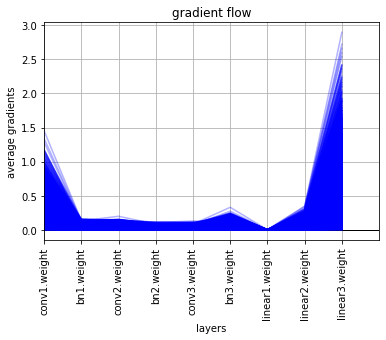

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


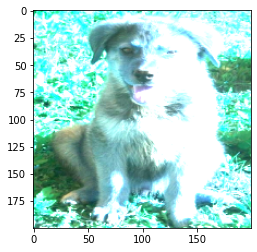

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


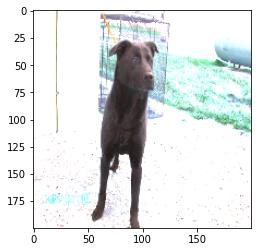

actual_label: Dog predicted_label: Dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


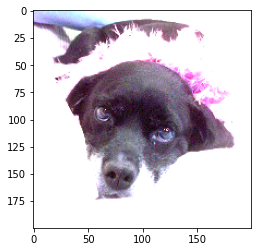

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


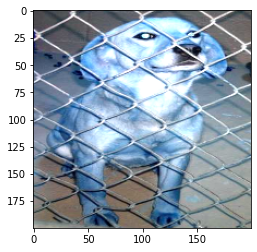

actual_label: Dog predicted_label: Dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


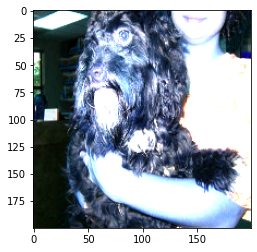

actual_label: Dog predicted_label: Dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


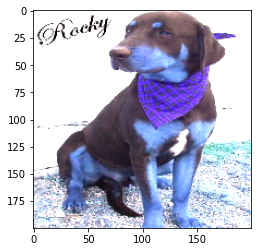

actual_label: Dog predicted_label: Cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


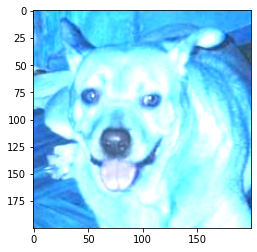

actual_label: Dog predicted_label: Dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


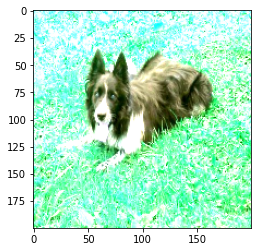

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


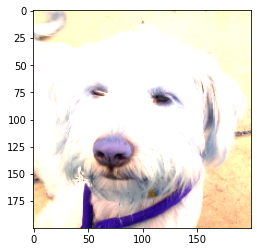

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: Dog predicted_label: Dog


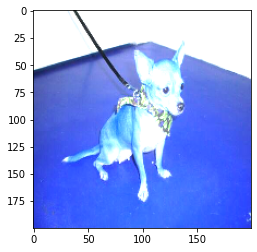


 test accuracy: 79.13647342995169 %


In [2]:

from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn
!pip install split-folders[full]
import splitfolders
import cv2
import glob
from torch.utils.data import Dataset,DataLoader


x_train = []
y_train = []

for folder in glob.glob("/DATA1/Chiranjeev/Cat_Dog/output6/train"+"/*"):
  for file1 in glob.glob(folder+"/*"):
    if folder.split("/")[-1] == 'Cat':
      x_train.append(file1)
      y_train.append(int(0))

    elif folder.split("/")[-1] == 'Dog':
      x_train.append(file1)
      y_train.append(int(1))

x_train = np.array(x_train)
y_train = np.array(y_train)


x_test = []
y_test = []

for folder in glob.glob("/DATA1/Chiranjeev/Cat_Dog/output6/val"+"/*"):
  for file1 in glob.glob(folder+"/*"):
    if folder.split("/")[-1] == 'Cat':
      x_test.append(file1)
      y_test.append(int(0))

    elif folder.split("/")[-1] == 'Dog':
      x_test.append(file1)
      y_test.append(int(1))

x_test = np.array(x_test)
y_test = np.array(y_test) 

np.save("/DATA1/Chiranjeev/Cat_Dog/cat_dog_x_train.npy",x_train)
np.save("/DATA1/Chiranjeev/Cat_Dog/cat_dog_y_train.npy",y_train)
np.save("/DATA1/Chiranjeev/Cat_Dog/cat_dog_x_test.npy",x_test)
np.save("/DATA1/Chiranjeev/Cat_Dog/cat_dog_y_test.npy",y_test)

# x_train = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_x_train.npy")
# y_train = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_y_train.npy")
# x_test = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_x_test.npy")
# y_test = np.load("/DATA1/Chiranjeev/Cat_Dog/cat_dog_y_test.npy")

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


def gradient_update_plot(named_parameters,flag=False):
    avg_gradients = []
    layers = []
    if flag == False:
        for n,p in named_parameters:
            if(p.requires_grad) and ('bias' not in n):
                layers.append(n)
                avg_gradients.append(p.grad.abs().mean())

        plt.plot(avg_gradients,alpha=0.3,color='b')
        plt.hlines(0,0,len(avg_gradients)+1,linewidth=1,color='k')
        plt.xlim(xmin=0,xmax=len(avg_gradients))
        plt.xticks(range(0,len(avg_gradients),1),layers,rotation='vertical')
        plt.xlabel('layers')
        plt.ylabel('average gradients')
        plt.title('gradient flow')
        plt.grid(True)
    if flag==True:
        plt.show()
        
class Cat_DOG(Dataset):

  def __init__(self,x_train,y_train,transform=None):

      self.x_train = x_train
      self.y_train = y_train
      self.transform = transform

  def __len__(self):
    return len(self.x_train)

  def __getitem__(self,idx):

    try:
        image = cv2.imread(self.x_train[idx].replace('/content/drive/MyDrive/','/DATA1/Chiranjeev/'))
        image = cv2.resize(image.astype(float),(200,200))
        label = self.y_train[idx]
    except:
        image = cv2.imread(self.x_train[idx-1].replace('/content/drive/MyDrive/','/DATA1/Chiranjeev/'))
        image = cv2.resize(image.astype(float),(200,200))
        label = self.y_train[idx-1]


    if self.transform:     
      image = self.transform(image)

    return image,label


class ToTransform:

  def __call__(self,image):

    trans = transforms.Compose([
                  transforms.ToTensor(),
                  transforms.RandomHorizontalFlip(),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                  ])
    image = trans(image)

    return image


train_dataset = Cat_DOG(x_train,y_train,transform = ToTransform())
test_dataset = Cat_DOG(x_test,y_test,transform = ToTransform())

batch_size = 16
trainloader = DataLoader(train_dataset,batch_size=batch_size,num_workers = 0, shuffle=True)#,worker_init_fn = np.random.seed(42))
testloader = DataLoader(test_dataset,batch_size=batch_size,num_workers = 0,shuffle=False)


print(len(trainloader))
print(len(testloader))


class CNN3(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv1 = nn.Conv2d(3,16,3)
    self.bn1 = nn.BatchNorm2d(16) 
    self.conv2 = nn.Conv2d(16,32,3)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32,32,3)
    self.bn3 = nn.BatchNorm2d(32)

    self.flatten_shape =  32 * 23 * 23
    self.linear1 = nn.Linear(in_features=self.flatten_shape,out_features=64)
    self.linear2 = nn.Linear(in_features=64, out_features=32)
    self.linear3 = nn.Linear(in_features=32, out_features=2)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d((2,2),stride=2)
    self.dropout = nn.Dropout(0.2)


  
  def forward(self,x):
    
    x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
    x = self.maxpool(self.relu(self.bn2(self.conv2(x))))
    x = self.maxpool(self.relu(self.bn3(self.conv3(x))))

    flat_features = x.reshape(-1, x.shape[1] * x.shape[2] * x.shape[3])
    x=self.dropout(flat_features)
    x=self.relu(self.linear1(x))
    x=self.relu(self.linear2(x))
    x=self.relu(self.linear3(x))

    return x


class_names = ['Cat', 'Dog']
def test(dataloader,model,criterion,purpose="test"):
    with torch.no_grad():
        test_loss = 0.0
        test_correct = 0
        for idx,batch in enumerate(dataloader):
            imgs,lbls = batch
            imgs = imgs.float()
            lbls = lbls.long()
            
            imgs = imgs.to(device)
            lbls = lbls.to(device)
            out = model(imgs)
            loss = criterion(out,lbls)

            test_loss += loss.item()
                
            test_pred = torch.argmax(out, dim=1)
            test_correct += torch.sum(test_pred == lbls)
            
        test_loss = test_loss/float(len(dataloader))
        test_acc = float(float(test_correct)/float(len(dataloader)*batch_size))

        if purpose == "test": 
            for idx,batch in enumerate(dataloader):
              imgs,lbls = batch
              imgs = imgs
              imgs = imgs.float().to(device)
              lbls = lbls.long().to(device)
              out = model(imgs)
              test_pred = torch.argmax(out, dim=1)
              for i in range(10):
                img = imgs[i]
                actual_lbl = lbls[i].detach().cpu().numpy()
                pred_lbl = test_pred[i].detach().cpu().numpy()

                img_disp = img.permute(1,2,0).detach().cpu().numpy()
                actual_lbl_disp = actual_lbl
                pred_lbl_disp = pred_lbl
                print("actual_label:",class_names[actual_lbl_disp],"predicted_label:",class_names[pred_lbl_disp])
                plt.imshow((img_disp/255.0))
                plt.show()
              break
                        
            
    
    return test_loss,test_acc



device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)


train_loss = []
validation_loss = []
train_acc = [] 
validation_acc = []

num_epochs = 12
learning_rate = 0.0001

model = CNN3()
model = model.to(device)

model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),betas=(0.0, 0.0),lr=learning_rate,weight_decay=1e-4)



for epoch in range(num_epochs):
  running_loss = 0.0
  running_correct = 0
  model.train()
  with tqdm(total=len(trainloader)) as pbar:  
    for idx,batch in enumerate(trainloader):
      imgs,lbls = batch
      imgs = imgs.float()
      lbls = lbls.long()
      
      imgs = imgs.to(device)
      lbls = lbls.to(device)

      optimizer.zero_grad()

      out = model(imgs)
      loss = criterion(out,lbls)

      loss.backward()
      gradient_update_plot(model.named_parameters())

      optimizer.step()

      running_loss += loss.item()
      num_correct = torch.sum(torch.argmax(out, dim=1) == lbls).item()

      running_correct += num_correct

            
      pbar.set_postfix(batch_loss='{}'.format(loss.item()))
      pbar.update(1)      

  
  train_loss.append(running_loss/float(len(trainloader)))
  train_acc.append(running_correct/float(len(trainloader)*batch_size))
  print(running_correct)

  print("\nepoch:",epoch," Train Loss:",running_loss/len(trainloader)," Train Accuracy:",running_correct/(len(trainloader)*batch_size))#" Validation Loss:",val_loss," Validation Accuracy:",val_acc,"\n")

gradient_update_plot(model.named_parameters(),flag=True)

model.eval()
test_loss,test_acc = test(testloader,model,criterion,purpose="test")
print("\n test accuracy:",test_acc*100,"%")





